---
---

# Difference Spec Code for SDSS and SAMI Spectra

---
---

## Imports

In [21]:
import matplotlib.pyplot as plt
import pylab as py
import numpy as np
import scipy as sp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.constants import c
import spectres
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from PyAstronomy import pyasl
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import simpson
from lmfit.models import GaussianModel
from astropy.cosmology import Planck18 as cosmo 

## Constants

In [22]:
OIII = 4983
SII = 6724 
H_ALPH = 6564.61
H_BETA = 4862.68

EPS = 1e-8
#TODO: remove testing
SMOOTH_FACTOR = 1.0
#

z = 0.0582

# From 2021 "The SAMI Galaxy Survey: the third and final data release"
"""
                                For the SAMI survey, we used the
580V and 1000R gratings, delivering a wavelength range of 3750-
5750 and 6300-7400 Å for the blue and red arms, respectively. The
spectral resolutions are R = 1808 and 4304 for the blue and red
arms, equivalent to an effective velocity dispersion of σ of 70.4 and
29.6 km s^{-1}, respectively
""";

RES_15_BLUE = 1808
RES_15_RED = 4304

# From 2014 "The SAMI Galaxy Survey: instrument specification and target selection"
"""
                                SAMI feeds the AAOmega spectrograph
(Sharp et al. 2006), which for the survey is set up to have resolu-
tions of R = 1730 in the blue arm and R = 4500 in the red arm.
""";

# R_15_blue = 1730
# R_15_red = 4500

# Average across all epochs and wavelength ranges
# SDSS_res = 2000
                                                                                #this marks 80 characters

## Reading functions
slightly edited versions of the original functions from Scott + extras

In [23]:
def sami_read_apspec(
    filename: str,
    extname: str,
    var_extname: str,
    doareacorr: bool = False,
    bugfix: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    hdulist = fits.open(filename)
    sami_flux = hdulist[extname].data
    header = hdulist[extname].header
    crval1=header['CRVAL1']
    cdelt1=header['CDELT1']
    crpix1=header['CRPIX1']
    naxis1=header['NAXIS1'] 
    x=np.arange(naxis1)+1
    L0=crval1-crpix1*cdelt1 #Lc-pix*dL        
    sami_lam = L0+x*cdelt1

    if (doareacorr):
        # fix bug in ap spec code:
        if (bugfix):
            areacorr=areacorr/2.0
        areacorr = header['AREACORR']
        sami_flux = sami_flux * areacorr

    #convert SAMI (wavelength in air) to wavelength in vacuum By default, the conversion specified by Ciddor 1996 are used.
    samivac_lam = pyasl.airtovac2(sami_lam)
    
    sami_flux *= 10 # flux unit conversion from 10e16 to 10e17 to match sdss

    
    sami_var = hdulist[var_extname].data #extract the variance array
    hdulist.close()
    return sami_flux, samivac_lam, sami_var

def sdss_read(
    infile: str, return_wresl: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    # get basic info on file:
    
    # opening file
    hdulist = fits.open(infile)
    hdr0 = fits.getheader(infile)
    hdr1 = hdulist['COADD'].header
    # read spectrum from COADD extension:
    sdss_spec_table = hdulist['COADD'].data
    sdss_flux = sdss_spec_table['flux']
    sdss_loglam = sdss_spec_table['loglam']

    # SDSS spectra are in log wavelength bins, to convert to linear:
    sdss_lam = 10.0**sdss_loglam
    # inverse variance
    sdss_ivar = sdss_spec_table['ivar']

    # close fits file:
    hdulist.close()

    # define parts of spectrum where data is likely to be good:
    idx = np.where((sdss_lam>3900) & (sdss_lam<9000))
    sdss_flux = sdss_flux[idx]
    sdss_lam = sdss_lam[idx]
    sdss_ivar = sdss_ivar[idx]
    if return_wresl:
        wresl = sdss_spec_table['wresl']
        wresl = wresl[idx]
        return sdss_flux, sdss_lam, sdss_ivar, wresl
    else:
        return sdss_flux, sdss_lam, sdss_ivar

In [35]:
def gaussian_blur_before_resample(
    low_res: np.ndarray | float, 
    high_res: np.ndarray | float, 
    lam_low_res: np.ndarray,            # should always be lam01?
    lam_high_res: np.ndarray,
    flux_high_res: np.ndarray,
    n_chunks: int = 100
) -> np.ndarray:
    """
    Gaussian blur using resolution (R = λ/FWHM) arrays.
    Degrades high_res spectrum to match low_res spectrum.
    """
    # Compute sigma arrays on their native grids
    sigma_low_res_arr = (lam_low_res / low_res) / 2.355
    
    sigma_high_res_arr = (lam_high_res / high_res) / 2.355

    #TODO: remove testing
    diffs = np.diff(lam_high_res)
    # print(f"Min step: {diffs.min()}, Max step: {diffs.max()}, Std/Mean: {diffs.std()/diffs.mean()}")
    n_smoothed = 0
    n_ignored = 0
    #

    blurred = flux_high_res.copy()
    chunk_size = len(lam_high_res) // n_chunks
    
    for i in range(n_chunks):
        high_res_chunk_start_idx = i * chunk_size
        high_res_chunk_end_idx = (i + 1) * chunk_size if i < n_chunks - 1 else len(lam_high_res)
        
        # Wavelength range for this chunk (on the high_res grid)
        lam_high_res_chunk = lam_high_res[high_res_chunk_start_idx:high_res_chunk_end_idx]
        lam_min = lam_high_res_chunk[0]
        lam_max = lam_high_res_chunk[-1]
        
        # Find low_res wavelengths that fall in this range
        low_res_lam_chunk_mask = (lam_low_res >= lam_min) & (lam_low_res <= lam_max)
        


        if np.any(low_res_lam_chunk_mask):
            # Compute median sigma in this chunk for both spectra
            sigma_low_res_chunk = sigma_low_res_arr[low_res_lam_chunk_mask]
            sigma_high_res_chunk = sigma_high_res_arr[high_res_chunk_start_idx:high_res_chunk_end_idx]
            sigma_low_res_median = np.median(sigma_low_res_chunk)
            sigma_high_res_median = np.median(sigma_high_res_chunk)

            #TODO: remove testing
            diffs = np.diff(lam_high_res_chunk)
            # print(f"\nChunk {i+1}\nMin step: {diffs.min()}, Max step: {diffs.max()}, Std/Mean: {diffs.std()/diffs.mean()}")
            #


            wavelength_step = np.median(np.diff(lam_high_res_chunk))

            # Note: should be median(sqrt(sigma_low^2 - sigma_high^2)) but
            # sqrt(median(sigma_low)^2 - median(sigma_high)^2) is a good approximation
            # since sigma_low and sigma_high are approximately constant across the chunk,
            # provided n_chunks is large enough.
            sigma_kernel_sq = sigma_low_res_median**2 - sigma_high_res_median**2

            #TODO: remove testing
            # If CV is small, values are approximately constant
            cv_low_res = np.std(sigma_low_res_chunk) / np.median(sigma_low_res_chunk)
            cv_high_res = np.std(sigma_high_res_chunk) / np.median(sigma_high_res_chunk)
            # Rule of thumb: CV < 0.05-0.10 means "approximately constant"
            # print(f"CV low res: {cv_low_res}, CV high res: {cv_high_res}")

            # Fractional spread within chunk
            spread_low = (np.max(sigma_low_res_chunk) - np.min(sigma_low_res_chunk)) / np.median(sigma_low_res_chunk)
            spread_high = (np.max(sigma_high_res_chunk) - np.min(sigma_high_res_chunk)) / np.median(sigma_high_res_chunk)
            # print(f"Spread low res: {spread_low}, Spread high res: {spread_high}")
            #

            if sigma_kernel_sq > EPS:
                #TODO: remove testing
                # print(f"sigma_kernel_sq: {sigma_kernel_sq}", flush=True)
                n_smoothed += 1
                #
                sigma_pix = np.sqrt(sigma_kernel_sq) / wavelength_step
                temp_blurred = gaussian_filter1d(flux_high_res, sigma=sigma_pix)
                blurred[high_res_chunk_start_idx:high_res_chunk_end_idx] = temp_blurred[high_res_chunk_start_idx:high_res_chunk_end_idx]
            #TODO: remove testing
            else:
                # print(f"too small sigma_kernel_sq: {sigma_kernel_sq}")
                # print(f"\tNo blurring applied in chunk {i+1}", flush=True)
                n_ignored += 1
            #
        else:
            raise ValueError("No low_res coverage in this chunk. This should never happen.")
    
    #TODO: remove testing
    # print(f"n_smoothed: {n_smoothed}, n_ignored: {n_ignored}")
    #
    return blurred

In [25]:
def gaussian_blur_after_resampling(
    low_res: np.ndarray | float, 
    high_res: np.ndarray | float, 
    lam: np.ndarray,
    flux_high_res: np.ndarray, 
    wavelength_step: float, 
    n_chunks: int = 20
) -> np.ndarray:
    """
    Gaussian blur using resolution (R = λ/FWHM) arrays.
    Degrades high_res spectrum to match low_res spectrum.
    
    Handles the case where high_res <= low_res at some wavelengths
    (no blurring needed there).
    """
    if np.isscalar(low_res):
        low_res = np.full_like(lam, low_res)
    if np.isscalar(high_res):
        high_res = np.full_like(lam, high_res)

    fwhm_low_res = lam / low_res
    fwhm_high_res = lam / high_res

    sigma_low_res = fwhm_low_res / 2.355
    sigma_high_res = fwhm_high_res / 2.355
    
    # Calculate the kernel sigma needed to convolve high_res to low_res
    # If high_res is already lower resolution, no blurring needed (set to 0)
    sigma_diff_sq = sigma_low_res**2 - sigma_high_res**2
    sigma_diff_sq = np.maximum(sigma_diff_sq, 0)  # Clamp negative values to 0
    sigma_kernel_arr = np.sqrt(sigma_diff_sq)
    
    blurred = flux_high_res.copy()
    chunk_size = len(lam) // n_chunks
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lam)
        
        sigma_pix = np.median(sigma_kernel_arr[start:end]) / wavelength_step
        
        if sigma_pix > EPS:
            temp_blurred = gaussian_filter1d(flux_high_res, sigma=sigma_pix)
            #TODO: remove testing
            # plt.plot(lam, flux_high_res)
            # plt.plot(lam, temp_blurred)
            # plt.xlim((lam[start], lam[end-1]))
            # plt.show()
            #
            blurred[start:end] = temp_blurred[start:end]
        # else: keep original flux (already copied above)
    
    #TODO: remove testing
    # plt.plot(lam, flux_high_res)
    # plt.plot(lam, blurred)
    # plt.show()
    #

    return blurred

In [26]:
def get_lam_bounds(emmited_lam: float, width: float) -> tuple[float, float]:
    obs_lam = emmited_lam*(1+z)
    left = obs_lam - width / 2
    right = obs_lam + width / 2
    return left, right

In [27]:
def clip_sami_blue_edge(
    unclipped_sami_flux: np.ndarray,
    unclipped_sami_lam: np.ndarray,
    unclipped_sami_var: np.ndarray,
    min_ssd_lam: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Clip the SAMI blue edge to the minimum SDSS wavelength.
    """
    # Find the index of the first wavelength greater than min_ssd_lam
    clip_idx = np.where(unclipped_sami_lam > min_ssd_lam)[0][0]
    
    # Clip the flux and variance arrays
    clipped_sami_flux = unclipped_sami_flux[clip_idx:]
    clipped_sami_lam = unclipped_sami_lam[clip_idx:]
    clipped_sami_var = unclipped_sami_var[clip_idx:]

    return clipped_sami_flux, clipped_sami_lam, clipped_sami_var


In [28]:
def get_min_res(
    res_01: np.ndarray,
    res_21: np.ndarray,
    res_22: np.ndarray,
    lam01: np.ndarray,
    lam15_blue: np.ndarray,
    lam15_red: np.ndarray,
    lam21: np.ndarray,
    lam22: np.ndarray,
    plot_anything: bool = True,
    plot_RES_15_RED: bool = False
) -> np.ndarray:
    """
    Plot the coverage of the resolution of the spectra.
    """
    # res_min = np.minimum(np.minimum(
    #     res_21, 
    #     res_22
    # ), RES_15_BLUE)

    #TODO: check logic with Scott
    res_min = np.minimum(
        res_21, 
        res_22
    )
    #

    res_min =  res_min / SMOOTH_FACTOR

    if not plot_anything:
        return res_min

    lam15_blue_min = np.min(lam15_blue)
    lam15_blue_max = np.max(lam15_blue)
    lam15_red_min = np.min(lam15_red)
    lam15_red_max = np.max(lam15_red)

    if plot_RES_15_RED:
        res_plot_bounds = [np.min(res_min), max(
            np.max(res_21), np.max(res_22), 
            np.max(res_01), RES_15_BLUE, RES_15_RED
        )]
    else:
        res_plot_bounds = [np.min(res_min), max(
            np.max(res_21), np.max(res_22), 
            np.max(res_01), RES_15_BLUE
        )]

    plt.axhline(RES_15_BLUE, color='blue', linestyle='--', label="SAMI blue")
    if plot_RES_15_RED:
        plt.axhline(RES_15_RED, color='red', linestyle='--', label="SAMI red")
    plt.plot(lam21, res_21, alpha=0.5, label="2021")
    plt.plot(lam22, res_22, alpha=0.5, label="2022")
    plt.plot(lam01, res_01, alpha=0.5, label="SDSS Average")
    plt.plot(lam01, res_min, color='black', alpha=0.5, lw=4, linestyle='--', label="Minimum")
    plt.fill_betweenx(res_plot_bounds, lam15_blue_min, lam15_blue_max, color='lightblue', alpha=0.5, label="SAMI blue coverage")
    plt.fill_betweenx(res_plot_bounds, lam15_red_min, lam15_red_max, color='red', alpha=0.2, label="SAMI red coverage")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Resolving Power")
    plt.title("Resolution of SDSS spectra")
    plt.legend()
    plt.show()

    return res_min

In [32]:
def get_data(
    blur_before_resampling: bool = True,
    plot_res_coverage: bool = False,
    plot_as_is: bool = False,
    plot_clipped: bool = False,
    plot_just_blurred: bool = False,
    plot_just_resampled: bool = False,
    plot_resampled_and_blurred: bool = True,
    final_plot_xlim: tuple[float, float] | None = None,
    final_plot_vlines: dict[str, float] | None = None,
    sdss_folder_name: str = "data/sami323854/sdss_data/",
    sami_folder_name: str = "data/sami323854/sami_data/",
    fname_2001: str = "spec-0469-51913-0338.fits",
    fname_2015_blue: str = "323854_A_spectrum_3-arcsec_blue.fits",
    fname_2015_red: str = "323854_A_spectrum_3-arcsec_red.fits",
    fname_2021: str = "spec-015167-59252-6747964707.fits",
    fname_2022: str = "spec-104405-59664-27021600108375953.fits"
) -> tuple[tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Get the flux, wavelength, and variance arrays for the spectra.
    """
    flux01, lam01, ivar01 = sdss_read(sdss_folder_name + fname_2001, return_wresl=False) # 2001 file
    flux21, lam21, ivar21, fwhm21 = sdss_read(sdss_folder_name + fname_2021) # 2021 file
    flux22, lam22, ivar22, fwhm22 = sdss_read(sdss_folder_name + fname_2022) # 2022 file
    
    flux15_blue, lam15_blue, var15_blue = sami_read_apspec(
        sami_folder_name + fname_2015_blue,
        "PRIMARY", "VARIANCE"
    ) # sami 3 arcsec blue file
    flux15_red, lam15_red, var15_red = sami_read_apspec(
        sami_folder_name + fname_2015_red,
        "PRIMARY", "VARIANCE"
    ) # sami 3 arcsec red file

    # inverse variance -> variance
    var01 = 1 / ivar01
    var21 = 1 / ivar21
    var22 = 1 / ivar22

    res_21 = lam21 / fwhm21
    res_22 = lam22 / fwhm22
    # Note: fwhm01 (wresl) not available
    res_01 = (res_21 + res_22) / 2
    #

    res_min = get_min_res(
        res_21,
        res_22,
        res_01,
        lam01,
        lam15_blue,
        lam15_red,
        lam21,
        lam22,
        plot_anything=plot_res_coverage
    )

    linewidth = 0.5

    if plot_as_is:
        plt.figure(figsize=(12,5))
        plt.plot(lam01, flux01, color='black', label='2001', lw = linewidth)
        plt.plot(lam15_blue, flux15_blue, color='blue', label='2015 blue arm', lw = linewidth)
        plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = linewidth)
        plt.plot(lam21, flux21, color='orange', label='2021', lw = linewidth)
        plt.plot(lam22, flux22, color='green', label='2022', lw = linewidth)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
        plt.title("Spectra 2001 - 2022")
        plt.legend()
        plt.show()

    err01 = np.sqrt(var01)
    err15_red = np.sqrt(var15_red)
    err21 = np.sqrt(var21)
    err22 = np.sqrt(var22)

    if blur_before_resampling:
        flux15_blue_clipped, lam15_blue_clipped, var15_blue_clipped = clip_sami_blue_edge(
            flux15_blue, lam15_blue, var15_blue, np.min(lam01)
        )
        err15_blue_clipped = np.sqrt(var15_blue_clipped)
        # Convert variance to standard deviation (error)

        if plot_clipped:
            plt.figure(figsize=(12,5))
            plt.plot(lam01, flux01, color='black', label='2001', lw = linewidth)
            plt.plot(lam15_blue_clipped, flux15_blue_clipped, color='blue', label='2015 blue arm', lw = linewidth)
            plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = linewidth)
            plt.plot(lam21, flux21, color='orange', label='2021', lw = linewidth)
            plt.plot(lam22, flux22, color='green', label='2022', lw = linewidth)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
            plt.title(f"Spectra 2001 - 2022 (SAMI clipped to ~{np.min(lam01):.0f} Å)")
            plt.legend()
            plt.show()
        
        flux01_blurred = gaussian_blur_before_resample(res_min, res_01, lam01, lam01, flux01)
        flux21_blurred = gaussian_blur_before_resample(res_min, res_21, lam01, lam21, flux21)
        flux22_blurred = gaussian_blur_before_resample(res_min, res_22, lam01, lam22, flux22)
        flux15_red_blurred = gaussian_blur_before_resample(res_min, RES_15_RED, lam01, lam15_red, flux15_red)
        flux15_blue_blurred = gaussian_blur_before_resample(res_min, RES_15_BLUE, lam01, lam15_blue_clipped, flux15_blue_clipped)

        if plot_just_blurred:
            plt.figure(figsize=(12,5))
            plt.plot(lam01, flux01_blurred, color='black', label='2001', lw = linewidth)
            plt.plot(lam15_blue_clipped, flux15_blue_blurred, color='blue', label='2015 blue arm', lw = linewidth)
            plt.plot(lam15_red, flux15_red_blurred, color='red', label='2015 red arm', lw = linewidth)
            plt.plot(lam21, flux21_blurred, color='orange', label='2021', lw = linewidth)
            plt.plot(lam22, flux22_blurred, color='green', label='2022', lw = linewidth)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
            plt.title("Spectra 2001 - 2022 (blurred before resampling)")
            plt.legend()
            plt.show()
                
        # Resample flux and errors together AFTER blurring
        flux01_blurred_shifted, err01_blurred_shifted = flux01_blurred, err01

        flux15_blue_blurred_shifted, err15_blue_blurred_shifted = spectres.spectres(
            lam01, lam15_blue_clipped, flux15_blue_blurred, spec_errs=err15_blue_clipped, fill=np.nan
        )
        flux15_red_blurred_shifted, err15_red_blurred_shifted = spectres.spectres(
            lam01, lam15_red, flux15_red_blurred, spec_errs=err15_red, fill=np.nan
        )
        flux21_blurred_shifted, err21_blurred_shifted = spectres.spectres(
            lam01, lam21, flux21_blurred, spec_errs=err21, fill=np.nan
        )
        flux22_blurred_shifted, err22_blurred_shifted = spectres.spectres(
            lam01, lam22, flux22_blurred, spec_errs=err22, fill=np.nan
        )
        
        var01_blurred_shifted = err01_blurred_shifted**2
        var15_blue_blurred_shifted = err15_blue_blurred_shifted**2
        var15_red_blurred_shifted = err15_red_blurred_shifted**2
        var21_blurred_shifted = err21_blurred_shifted**2
        var22_blurred_shifted = err22_blurred_shifted**2

        flux15_blurred_shifted = np.fmax(flux15_blue_blurred_shifted, flux15_red_blurred_shifted)
        if (
            np.sum(np.isfinite(flux15_blue_blurred_shifted)) +
            np.sum(np.isfinite(flux15_red_blurred_shifted)) !=
            np.sum(np.isfinite(flux15_blurred_shifted))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")

        var15_blurred_shifted = np.fmax(var15_blue_blurred_shifted, var15_red_blurred_shifted)
        if (
            np.sum(np.isfinite(var15_blue_blurred_shifted)) +
            np.sum(np.isfinite(var15_red_blurred_shifted)) !=
            np.sum(np.isfinite(var15_blurred_shifted))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")
        
        if plot_resampled_and_blurred:
            plt.figure(figsize=(12,5))
            plt.plot(lam01, flux01_blurred_shifted, color='black', label='2001', lw = linewidth)
            plt.plot(lam01, flux15_blurred_shifted, color='blue', label='2015', lw = linewidth)
            plt.plot(lam01, flux21_blurred_shifted, color='orange', label='2021', lw = linewidth)
            plt.plot(lam01, flux22_blurred_shifted, color='green', label='2022', lw = linewidth)

            if final_plot_vlines is not None:
                cmap = plt.cm.tab10  # or 'Set1', 'Dark2', etc.
                for i, (name, emission_lam) in enumerate(final_plot_vlines.items()):
                    if final_plot_xlim is None or (final_plot_xlim[0] < emission_lam < final_plot_xlim[1]):
                        plt.axvline(
                            emission_lam * (1+z), linestyle='--', lw=linewidth,
                            color=cmap(i), label=name
                        )
            if final_plot_xlim is not None:
                plt.xlim(final_plot_xlim)

            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
            plt.title("Spectra 2001 - 2022 (blurred then resampled to 2001 grid)")
            plt.legend()
            plt.show()
        
        data01 = (flux01_blurred_shifted, var01_blurred_shifted)
        data15 = (flux15_blurred_shifted, var15_blurred_shifted)
        data21 = (flux21_blurred_shifted, var21_blurred_shifted)
        data22 = (flux22_blurred_shifted, var22_blurred_shifted)

    else:
        err15_blue = np.sqrt(var15_blue)

        # Resample flux and errors together AFTER blurring
        flux01_shifted, err01_shifted = flux01, err01

        flux15_blue_shifted, err15_blue_shifted = spectres.spectres(
            lam01, lam15_blue_clipped, flux15_blue, spec_errs=err15_blue, fill=np.nan
        )
        flux15_red_shifted, err15_red_shifted = spectres.spectres(
            lam01, lam15_red, flux15_red, spec_errs=err15_red, fill=np.nan
        )
        flux21_shifted, err21_shifted = spectres.spectres(
            lam01, lam21, flux21, spec_errs=err21, fill=np.nan
        )
        flux22_shifted, err22_shifted = spectres.spectres(
            lam01, lam22, flux22, spec_errs=err22, fill=np.nan
        )

        var15_blue_shifted = err15_blue_shifted**2
        var15_red_shifted = err15_red_shifted**2
        var21_shifted = err21_shifted**2
        var22_shifted = err22_shifted**2

        if plot_just_resampled:
            plt.figure(figsize=(12,5))
            plt.plot(lam01, flux01_shifted, color='black', label='2001', lw = linewidth)
            plt.plot(lam01, flux15_blue_shifted, color='blue', label='2015 blue arm', lw = linewidth)
            plt.plot(lam01, flux15_red_shifted, color='red', label='2015 red arm', lw = linewidth)
            plt.plot(lam01, flux21_shifted, color='orange', label='2021', lw = linewidth)
            plt.plot(lam01, flux22_shifted, color='green', label='2022', lw = linewidth)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
            plt.title("Spectra 2001 - 2022 (resampled to 2001 grid)")
            plt.legend()
            plt.show()

        wavelength_step = np.median(np.diff(lam01))

        flux01_shifted_blurred = gaussian_blur_after_resampling(res_min, res_01, lam01, flux01_shifted, wavelength_step)
        flux21_shifted_blurred = gaussian_blur_after_resampling(res_min, res_21, lam01, flux21_shifted, wavelength_step)
        flux22_shifted_blurred = gaussian_blur_after_resampling(res_min, res_22, lam01, flux22_shifted, wavelength_step)
        flux15_red_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_RED, lam01, flux15_red_shifted, wavelength_step)
        flux15_blue_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_BLUE, lam01, flux15_blue_shifted, wavelength_step)

        flux15_shifted_blurred = np.fmax(flux15_blue_shifted_blurred, flux15_red_shifted_blurred)
        if (
            np.sum(np.isfinite(flux15_blue_shifted_blurred)) +
            np.sum(np.isfinite(flux15_red_shifted_blurred)) !=
            np.sum(np.isfinite(flux15_shifted_blurred))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")

        var15_shifted_blurred = np.fmax(var15_blue_shifted_blurred, var15_red_shifted_blurred)
        if (
            np.sum(np.isfinite(var15_blue_shifted_blurred)) +
            np.sum(np.isfinite(var15_red_shifted_blurred)) !=
            np.sum(np.isfinite(var15_shifted_blurred))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")
        
        if plot_resampled_and_blurred:
            plt.figure(figsize=(12,5))
            plt.plot(lam01, flux01_shifted_blurred, color='black', label='2001', lw = linewidth)
            plt.plot(lam01, flux15_shifted_blurred, color='purple', label='2015', lw = linewidth)
            plt.plot(lam01, flux21_shifted_blurred, color='orange', label='2021', lw = linewidth)
            plt.plot(lam01, flux22_shifted_blurred, color='green', label='2022', lw = linewidth)

            if final_plot_vlines is not None:
                cmap = plt.cm.tab10  # or 'Set1', 'Dark2', etc.
                for i, (name, emission_lam) in enumerate(final_plot_vlines.items()):
                    if final_plot_xlim is None or (final_plot_xlim[0] < emission_lam < final_plot_xlim[1]):
                        plt.axvline(
                            emission_lam * (1+z), linestyle='--', lw=linewidth,
                            color=cmap(i), label=name
                        )
            if final_plot_xlim is not None:
                plt.xlim(final_plot_xlim)

            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
            plt.title("Spectra 2001 - 2022 (resampled to 2001 grid then blurred)")
            plt.legend()
            plt.show()
        
        data01 = (flux01_shifted_blurred, var01_shifted_blurred)
        data15 = (flux15_shifted_blurred, var15_shifted_blurred)
        data21 = (flux21_shifted_blurred, var21_shifted_blurred)
        data22 = (flux22_shifted_blurred, var22_shifted_blurred)

    return lam01, (data01, data15, data21, data22)

## Reading in data

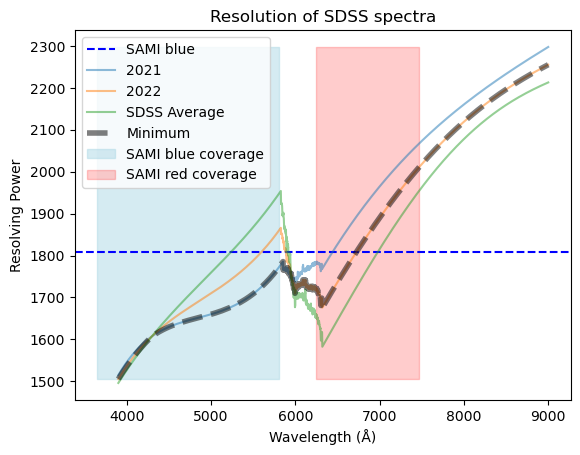

/opt/anaconda3/envs/denison/lib/python3.11/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


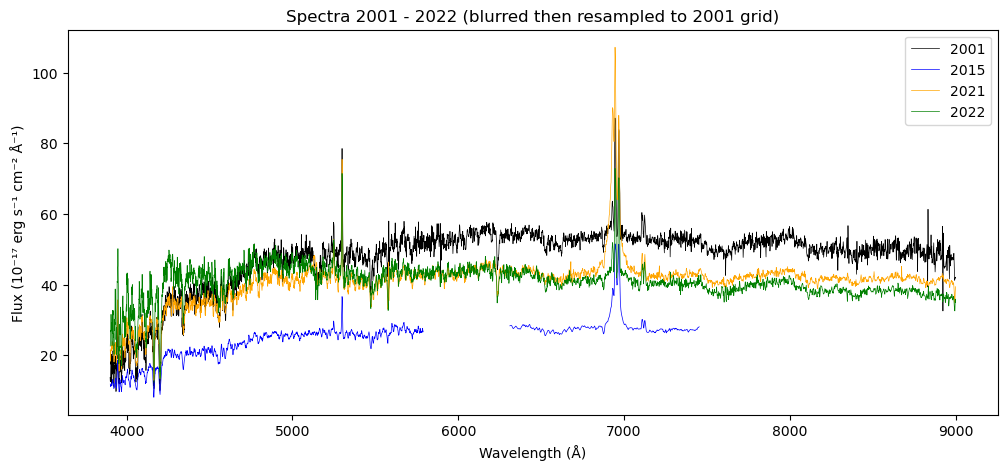

In [37]:
lam, (data01, data15, data21, data22) = get_data(plot_res_coverage=True)
flux01, var01 = data01
flux15, var15 = data15
flux21, var21 = data21
flux22, var22 = data22

In [185]:
# reading in the files

sdss_folder_name = "data/sami323854/sdss_data/"
sami_folder_name = "data/sami323854/sami_data/"
fname_2001 = sdss_folder_name + "spec-0469-51913-0338.fits"
fname_2015_blue = sami_folder_name + "323854_A_spectrum_3-arcsec_blue.fits"
fname_2015_red = sami_folder_name + "323854_A_spectrum_3-arcsec_red.fits"
fname_2021 = sdss_folder_name + "spec-015167-59252-6747964707.fits"
fname_2022 = sdss_folder_name + "spec-104405-59664-27021600108375953.fits"

flux01, lam01, ivar01 = sdss_read(fname_2001, return_wresl=False) # 2001 file
flux15_blue, lam15_blue, var15_blue = sami_read_apspec(fname_2015_blue, "PRIMARY", "VARIANCE") # sami 3 arcsec blue file
flux15_red, lam15_red, var15_red = sami_read_apspec(fname_2015_red, "PRIMARY", "VARIANCE") # sami 3 arcsec red file
flux21, lam21, ivar21, fwhm21 = sdss_read(fname_2021) # 2021 file
flux22, lam22, ivar22, fwhm22 = sdss_read(fname_2022) # 2022 file

# inverse variance -> variance
var01 = 1 / ivar01
var21 = 1 / ivar21
var22 = 1 / ivar22

Plotting resolution

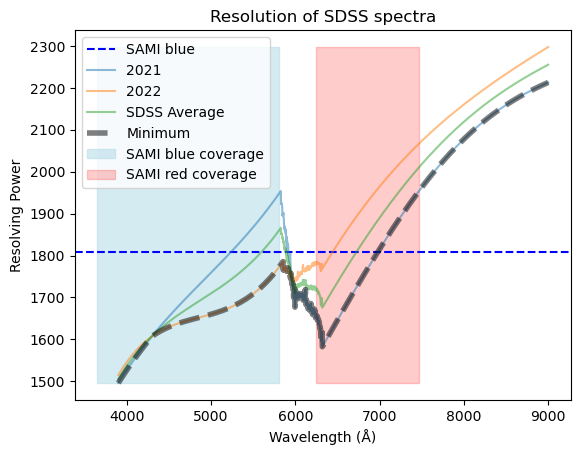

In [186]:
res_21 = lam21 / fwhm21
res_22 = lam22 / fwhm22
# Note: fwhm01 (wresl) not available
res_01 = (res_21 + res_22) / 2
#

res_min = np.minimum(np.minimum(
    res_21, 
    res_22
), RES_15_BLUE)

#TODO: check logic with Scott
res_min = np.minimum(
    res_21, 
    res_22
)
#

res_min =  res_min / SMOOTH_FACTOR

lam15_blue_min = np.min(lam15_blue)
lam15_blue_max = np.max(lam15_blue)
lam15_red_min = np.min(lam15_red)
lam15_red_max = np.max(lam15_red)

res_plot_bounds = [np.min(res_min), max(
    np.max(res_21), np.max(res_22), 
    np.max(res_01), RES_15_BLUE#, RES_15_RED
)]

plt.axhline(RES_15_BLUE, color='blue', linestyle='--', label="SAMI blue")
# plt.axhline(R_15_red, color='red', linestyle='--', label="SAMI red")
plt.plot(lam21, res_21, alpha=0.5, label="2021")
plt.plot(lam22, res_22, alpha=0.5, label="2022")
plt.plot(lam01, res_01, alpha=0.5, label="SDSS Average")
plt.plot(lam01, res_min, color='black', alpha=0.5, lw=4, linestyle='--', label="Minimum")
plt.fill_betweenx(res_plot_bounds, lam15_blue_min, lam15_blue_max, color='lightblue', alpha=0.5, label="SAMI blue coverage")
plt.fill_betweenx(res_plot_bounds, lam15_red_min, lam15_red_max, color='red', alpha=0.2, label="SAMI red coverage")


plt.xlabel("Wavelength (Å)")
plt.ylabel("Resolving Power")
plt.title("Resolution of SDSS spectra")
plt.legend()
plt.show()

In [187]:
# lam_range_01 = np.max(lam01) - np.min(lam01)
# lam_range_15_blue = np.max(lam15_blue) - np.min(lam15_blue)
# lam_range_15_red = np.max(lam15_red) - np.min(lam15_red)
# lam_range_15 = lam_range_15_blue + lam_range_15_red
# lam_range_21 = np.max(lam21) - np.min(lam21)
# lam_range_22 = np.max(lam22) - np.min(lam22)

# data_points_per_angstrom_01 = len(lam01) / lam_range_01
# data_points_per_angstrom_15_red = len(lam15_red) / lam_range_15_red
# data_points_per_angstrom_15_blue = len(lam15_blue) / lam_range_15_blue
# data_points_per_angstrom_15 = (len(lam15_blue) + len(lam15_red)) / lam_range_15
# data_points_per_angstrom_21 = len(lam21) / lam_range_21
# data_points_per_angstrom_22 = len(lam22) / lam_range_22

# print(len(lam01)//100)
# print(len(lam15_blue)//100)
# print(len(lam15_red)//100)
# print(len(lam21)//100)
# print(len(lam22)//100)
# print()
# print(lam_range_01)
# print(lam_range_15_blue)
# print(lam_range_15_red)
# print(lam_range_15)
# print(lam_range_21)
# print(lam_range_22)
# print()
# print(data_points_per_angstrom_01)
# print(data_points_per_angstrom_15)
# print(data_points_per_angstrom_15_blue)
# print(data_points_per_angstrom_15_red)
# print(data_points_per_angstrom_21)
# print(data_points_per_angstrom_22)

Plotting the spectra as is

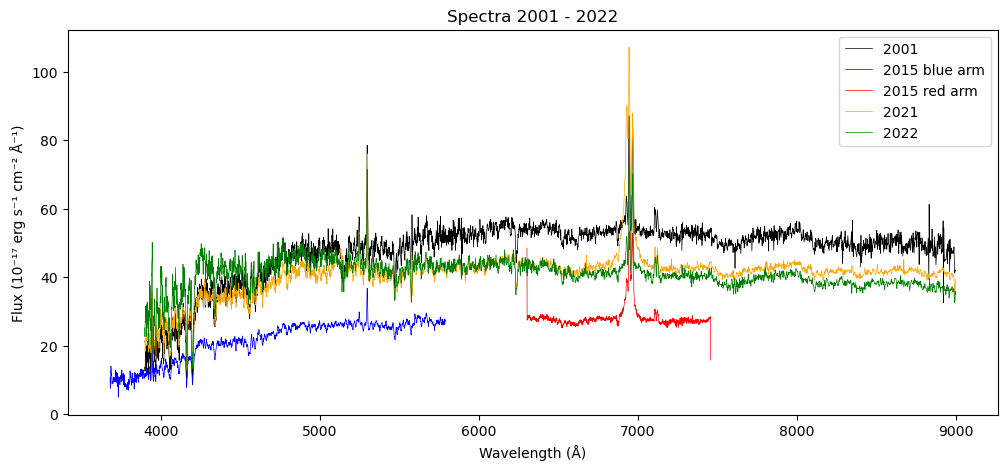

In [188]:
linewidth = 0.5

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01, color='black', label='2001', lw = linewidth)
plt.plot(lam15_blue, flux15_blue, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam21, flux21, color='orange', label='2021', lw = linewidth)
plt.plot(lam22, flux22, color='green', label='2022', lw = linewidth)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001 - 2022")
plt.legend()
plt.show()

In [189]:
flux15_blue_clipped, lam15_blue_clipped, var15_blue_clipped = clip_sami_blue_edge(flux15_blue, lam15_blue, var15_blue, np.min(lam01))

Plotting the clipped SAMI spectra

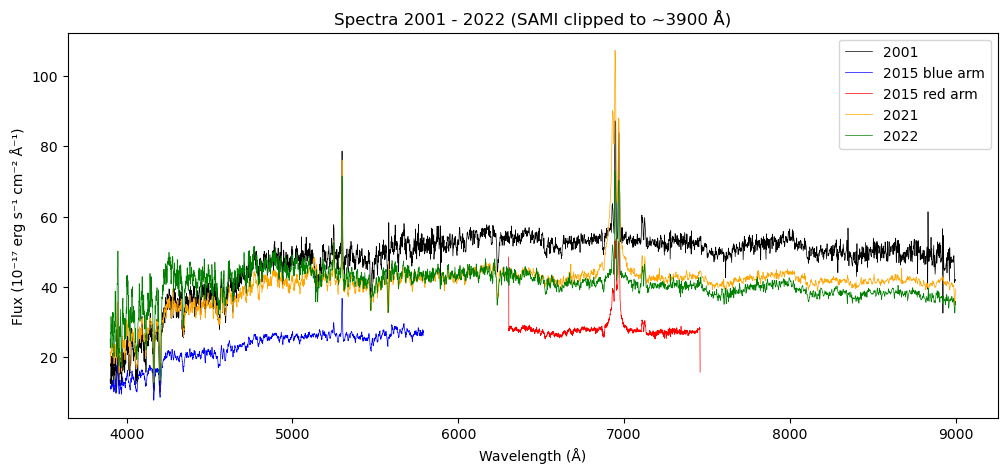

In [190]:
linewidth = 0.5

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01, color='black', label='2001', lw = linewidth)
plt.plot(lam15_blue_clipped, flux15_blue_clipped, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam21, flux21, color='orange', label='2021', lw = linewidth)
plt.plot(lam22, flux22, color='green', label='2022', lw = linewidth)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title(f"Spectra 2001 - 2022 (SAMI clipped to ~{np.min(lam01):.0f} Å)")
plt.legend()
plt.show()

Try blurring *before* resampling (sigmas calculated by binned median)

In [191]:
# # Blur SDSS spectra

flux01_blurred = gaussian_blur_before_resample(res_min, res_01, lam01, lam01, flux01)
flux21_blurred = gaussian_blur_before_resample(res_min, res_21, lam01, lam21, flux21)
flux22_blurred = gaussian_blur_before_resample(res_min, res_22, lam01, lam22, flux22)
flux15_red_blurred = gaussian_blur_before_resample(res_min, RES_15_RED, lam01, lam15_red, flux15_red)
flux15_blue_blurred = gaussian_blur_before_resample(res_min, RES_15_BLUE, lam01, lam15_blue_clipped, flux15_blue_clipped)

n_smoothed: 100, n_ignored: 0
n_smoothed: 50, n_ignored: 50
n_smoothed: 64, n_ignored: 36
n_smoothed: 100, n_ignored: 0
n_smoothed: 100, n_ignored: 0


Plotting blurred spectra (before resampling)

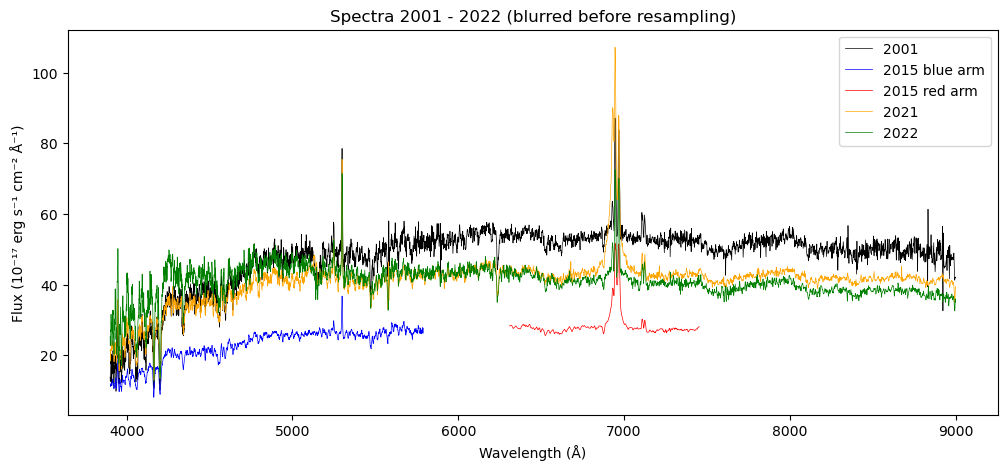

In [192]:
plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_blurred, color='black', label='2001', lw = linewidth)
plt.plot(lam15_blue_clipped, flux15_blue_blurred, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam15_red, flux15_red_blurred, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam21, flux21_blurred, color='orange', label='2021', lw = linewidth)
plt.plot(lam22, flux22_blurred, color='green', label='2022', lw = linewidth)
plt.xlabel("Wavelength (Å)")

# plt.xlim(get_lam_bounds(SII, 200))
# plt.axvline(SII*(1+z), color='black', linestyle='--', lw=linewidth, label="SII")

plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001 - 2022 (blurred before resampling)")
plt.legend()
plt.show()

In [193]:
# Convert variance to standard deviation (error)
err15_blue_clipped = np.sqrt(var15_blue_clipped)
#TODO: remove 
err15_blue = np.sqrt(var15_blue)
#
err15_red = np.sqrt(var15_red)
err21 = np.sqrt(var21)
err22 = np.sqrt(var22)

In [ ]:
# Resample flux and errors together AFTER blurring

#TODO: make better names for 2001 (variance) variables
flux01_blurred_shifted, _ = flux01_blurred, _

flux15_blue_blurred_shifted, err15_blue_blurred_shifted = spectres.spectres(
    lam01, lam15_blue_clipped, flux15_blue_blurred, spec_errs=err15_blue_clipped, fill=np.nan
)
flux15_red_blurred_shifted, err15_red_blurred_shifted = spectres.spectres(
    lam01, lam15_red, flux15_red_blurred, spec_errs=err15_red, fill=np.nan
)
flux21_blurred_shifted, err21_blurred_shifted = spectres.spectres(
    lam01, lam21, flux21_blurred, spec_errs=err21, fill=np.nan
)
flux22_blurred_shifted, err22_blurred_shifted = spectres.spectres(
    lam01, lam22, flux22_blurred, spec_errs=err22, fill=np.nan
)

flux15_blurred_shifted = np.fmax(flux15_blue_blurred_shifted, flux15_red_blurred_shifted)

if (
    np.sum(np.isfinite(flux15_blue_blurred_shifted)) +
    np.sum(np.isfinite(flux15_red_blurred_shifted)) !=
    np.sum(np.isfinite(flux15_blurred_shifted))
):
    raise ValueError("ERROR: mismatch in number of non-nan values")

/opt/anaconda3/envs/denison/lib/python3.11/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [195]:
# Resample flux and errors together BEFORE blurring

flux01_shifted, _ = flux01, _

flux15_blue_shifted, err15_blue_shifted = spectres.spectres(
    lam01, lam15_blue, flux15_blue, spec_errs=err15_blue, fill=np.nan
)
flux15_red_shifted, err15_red_shifted = spectres.spectres(
    lam01, lam15_red, flux15_red, spec_errs=err15_red, fill=np.nan
)
flux21_shifted, err21_shifted = spectres.spectres(
    lam01, lam21, flux21, spec_errs=err21, fill=np.nan
)
flux22_shifted, err22_shifted = spectres.spectres(
    lam01, lam22, flux22, spec_errs=err22, fill=np.nan
)

In [196]:
# Convert back to variance if needed
var15_blue_blurred_shifted = err15_blue_blurred_shifted**2
var15_red_blurred_shifted = err15_red_blurred_shifted**2
var21_blurred_shifted = err21_blurred_shifted**2
var22_blurred_shifted = err22_blurred_shifted**2

In [197]:
# Convert back to variance if needed
var15_blue_shifted = err15_blue_shifted**2
var15_red_shifted = err15_red_shifted**2
var21_shifted = err21_shifted**2
var22_shifted = err22_shifted**2

Plotting `spectres` shifted spectra (*after* blurring)

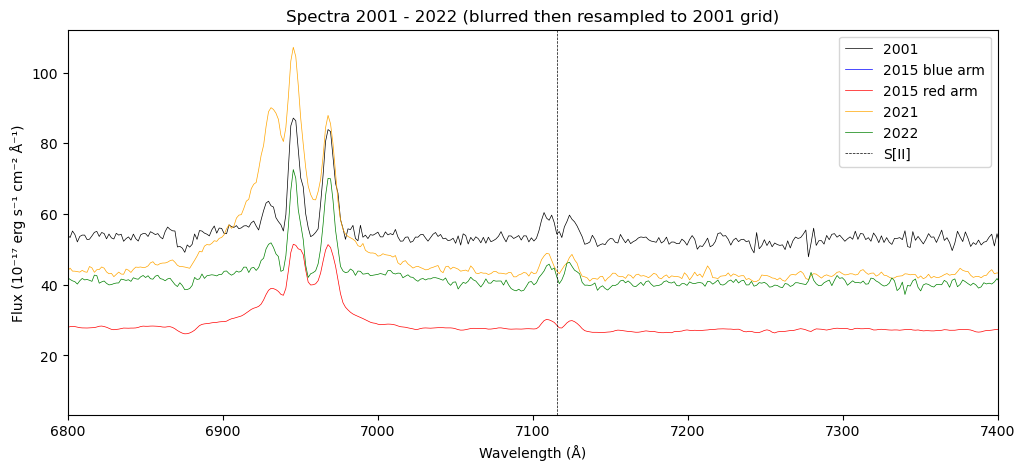

In [198]:
linewidth = 0.5

# approx_sf_15_01 = np.nanmean(flux15_red_shifted) / np.nanmean(flux01)
approx_sf_15_01 = 29/55
approx_sf_21_01 = 44/55

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_blurred_shifted, color='black', label='2001', lw = linewidth)
plt.plot(lam01, flux15_blue_blurred_shifted, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam01, flux15_red_blurred_shifted, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam01, flux21_blurred_shifted, color='orange', label='2021', lw = linewidth)
plt.plot(lam01, flux22_blurred_shifted, color='green', label='2022', lw = linewidth)
plt.axvline(SII*(1+z), color='black', linestyle='--', lw=linewidth, label="S[II]")
plt.xlim((6800, 7400))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001 - 2022 (blurred then resampled to 2001 grid)")
plt.legend()
plt.show()

Plotting `spectres` shifted spectra (*without* blurring)

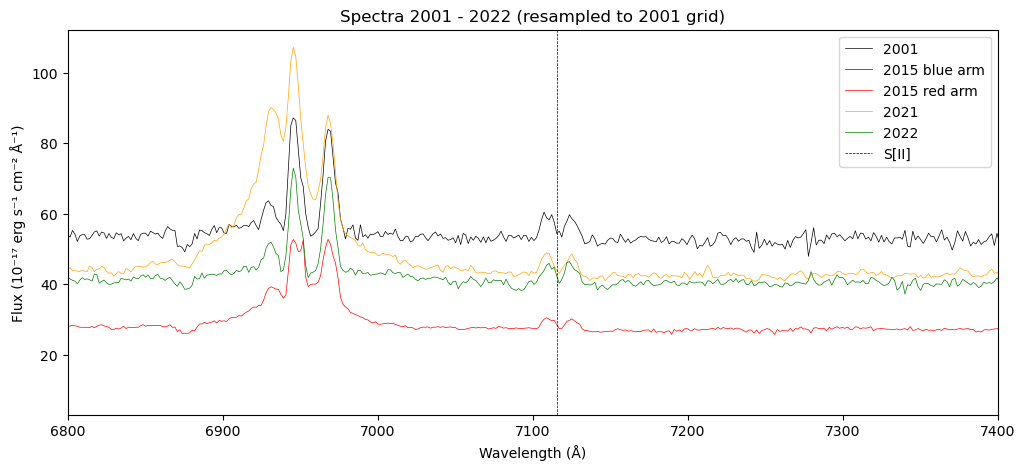

In [199]:
linewidth = 0.5

# approx_sf_15_01 = np.nanmean(flux15_red_shifted) / np.nanmean(flux01)
approx_sf_15_01 = 29/55
approx_sf_21_01 = 44/55

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_shifted, color='black', label='2001', lw = linewidth)
plt.plot(lam01, flux15_blue_shifted, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam01, flux15_red_shifted, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam01, flux21_shifted, color='orange', label='2021', lw = linewidth)
plt.plot(lam01, flux22_shifted, color='green', label='2022', lw = linewidth)
plt.axvline(SII*(1+z), color='black', linestyle='--', lw=linewidth, label="S[II]")
plt.xlim((6800, 7400))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001 - 2022 (resampled to 2001 grid)")
plt.legend()
plt.show()

In [200]:
# wavelength_step = np.median(np.diff(lam01))

# # Resample resolution arrays to lam01 grid
# res_21_shifted = np.interp(lam01, lam21, res_21)
# res_22_shifted = np.interp(lam01, lam22, res_22)
# res_01 = (res_21_shifted + res_22_shifted) / 2

# # Now res_min should use the shifted version
# res_min = np.minimum(np.minimum(res_21_shifted, res_22_shifted), RES_15_BLUE)

# # And blur with consistent arrays
# flux01_blurred = gaussian_blur_to_match_fwhm(res_min, res_01, lam01, flux01, wavelength_step)
# flux21_blurred = gaussian_blur_to_match_fwhm(res_min, res_21_shifted, lam01, flux21_shifted, wavelength_step)
# flux22_blurred = gaussian_blur_to_match_fwhm(res_min, res_22_shifted, lam01, flux22_shifted, wavelength_step)
# flux15_red_blurred = gaussian_blur_to_match_fwhm(res_min, RES_15_RED, lam01, flux15_red_shifted, wavelength_step)
# flux15_blue_blurred = gaussian_blur_to_match_fwhm(res_min, RES_15_BLUE, lam01, flux15_blue_shifted, wavelength_step)


# flux15_blurred = np.fmax(flux15_blue_blurred, flux15_red_blurred)

In [ ]:
# # Blur SDSS spectra

wavelength_step = np.median(np.diff(lam01))

# flux01_blurred = gaussian_blur(R_15_blue, SDSS_res, lam01, flux01, wavelength_step)
# flux21_blurred = gaussian_blur(R_15_blue, SDSS_res, lam01, flux21_shifted, wavelength_step)
# flux22_blurred = gaussian_blur(R_15_blue, SDSS_res, lam01, flux22_shifted, wavelength_step)

#TODO: remove testing
# res_min = RES_15_BLUE * 0.02
# RES_15_BLUE /= 8
# RES_15_RED /= 8
#

flux01_shifted_blurred = gaussian_blur_after_resampling(res_min, res_01, lam01, flux01_shifted, wavelength_step)
flux21_shifted_blurred = gaussian_blur_after_resampling(res_min, res_21, lam01, flux21_shifted, wavelength_step)
flux22_shifted_blurred = gaussian_blur_after_resampling(res_min, res_22, lam01, flux22_shifted, wavelength_step)
flux15_red_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_RED, lam01, flux15_red_shifted, wavelength_step)
flux15_blue_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_BLUE, lam01, flux15_blue_shifted, wavelength_step)


flux15_shifted_blurred = np.fmax(flux15_blue_shifted_blurred, flux15_red_shifted_blurred)

Plotting resampled *then* blurred spectra

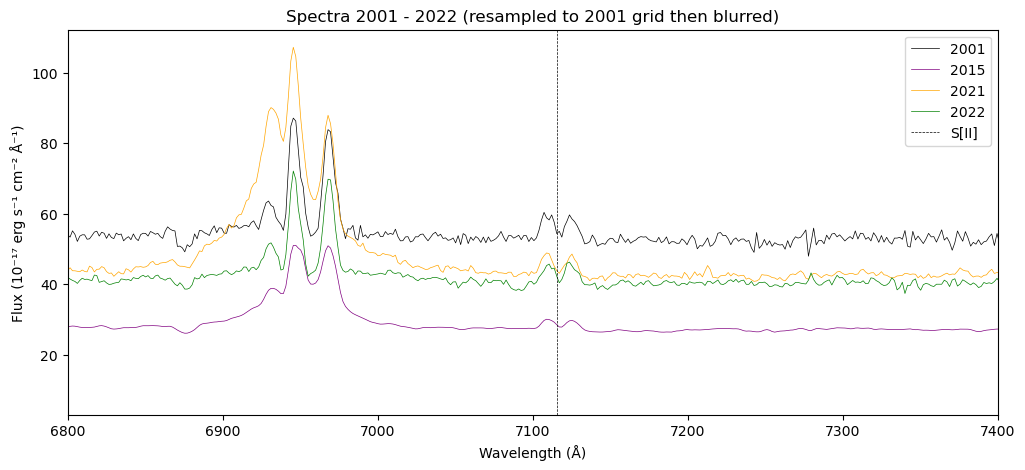

In [202]:
linewidth = 0.5

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_shifted_blurred, color='black', label='2001', lw = linewidth)
# plt.plot(lam01, flux15_blue_blurred, color='blue', label='2015 blue arm', lw = linewidth)
# plt.plot(lam01, flux15_red_blurred, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam01, flux15_shifted_blurred, color='purple', label='2015', lw = linewidth)
plt.plot(lam01, flux21_shifted_blurred, color='orange', label='2021', lw = linewidth)
plt.plot(lam01, flux22_shifted_blurred, color='green', label='2022', lw = linewidth)
plt.axvline(SII*(1+z), color='black', linestyle='--', lw=linewidth, label="S[II]")
plt.xlim((6800, 7400))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001 - 2022 (resampled to 2001 grid then blurred)")
plt.legend()
plt.show()

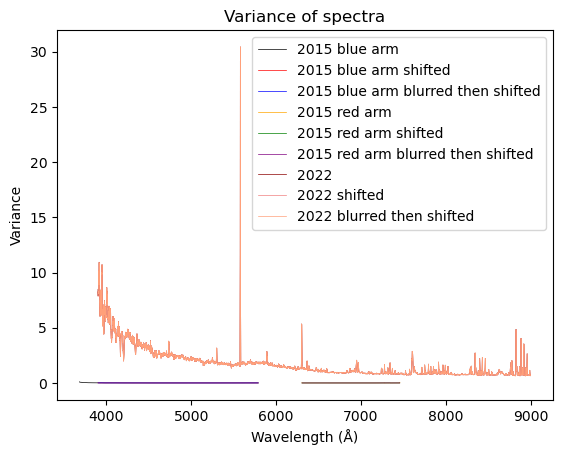

In [203]:
#TODO: figure out what's going on here

plt.plot(lam15_blue, var15_blue, color='black', label='2015 blue arm', lw = linewidth)
plt.plot(lam01, var15_blue_shifted, color='red', label='2015 blue arm shifted', lw = linewidth)
plt.plot(lam01, var15_blue_blurred_shifted, color='blue', label='2015 blue arm blurred then shifted', lw = linewidth)
plt.plot(lam15_red, var15_red, color='orange', label='2015 red arm', lw = linewidth)
plt.plot(lam01, var15_red_shifted, color='green', label='2015 red arm shifted', lw = linewidth)
plt.plot(lam01, var15_red_blurred_shifted, color='purple', label='2015 red arm blurred then shifted', lw = linewidth)
# plt.plot(lam21, var21, color='yellow', label='2021', lw = linewidth)
# plt.plot(lam01, var21_shifted, color='brown', label='2021 shifted', lw = linewidth)
# plt.plot(lam01, var21_blurred_shifted, color='pink', label='2021 blurred then shifted', lw = linewidth)
plt.plot(lam22, var22, color="darkred", label='2022', lw = linewidth)
plt.plot(lam01, var22_shifted, color='lightcoral', label='2022 shifted', lw = linewidth)
plt.plot(lam01, var22_blurred_shifted, color='lightsalmon', label='2022 blurred then shifted', lw = linewidth)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Variance")
plt.title("Variance of spectra")
plt.legend()
plt.show()

## Fitting a polynomial to ratio of different epochs to normalise

Calibration adjustment functions

In [204]:
def bin_data_by_median(x: np.ndarray, y: np.ndarray, bin_width: float) -> tuple[np.ndarray, np.ndarray]:
    step_size = np.median(np.diff(x))

    points_per_bin = int(bin_width / step_size)

    n_complete_bins = len(y) // points_per_bin
    n_points_to_keep = n_complete_bins * points_per_bin

    x_trimmed = x[:n_points_to_keep]
    y_trimmed = y[:n_points_to_keep]

    x_2d = x_trimmed.reshape(n_complete_bins, points_per_bin)
    y_2d = y_trimmed.reshape(n_complete_bins, points_per_bin)

    x_binned = np.median(x_2d, axis=1)
    y_binned = np.median(y_2d, axis=1)

    return x_binned, y_binned

#TODO: fit polynomial to variances as well

def plot_polynom_fit(
    lambdas: np.ndarray, vals: np.ndarray,
    degree: float = 6, bin_width: float = 40,
    bin_by_med: bool = True, plot_result: bool = True,
    title: str = "Spectrum ratio of 2022 to 2001 (blurred and resampled to 2001 grid)"
) -> tuple[np.poly1d, np.ndarray]:
    if bin_by_med:
        new_lambdas, new_vals = bin_data_by_median(lambdas, vals, bin_width)
    else:
        new_vals = vals
        new_lambdas = lambdas

    valid_mask = np.isfinite(new_vals)
    coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
    polynom = np.poly1d(coefficients)
    polynom_vals = polynom(new_lambdas)

    valid_indices = np.where(valid_mask)[0]
    first_valid = valid_indices[0]
    last_valid = valid_indices[-1]

    outer_mask = np.zeros_like(valid_mask, dtype=bool)
    outer_mask[:first_valid] = True
    outer_mask[last_valid + 1:] = True

    polynom_vals[outer_mask] = np.nan

    if plot_result:
        linewidth = 0.5
        plt.figure(figsize=(12,5))
        plt.plot(lambdas, vals, alpha=0.5, color='black', label='actual ratio', lw = linewidth)
        if bin_by_med:
            plt.plot(new_lambdas, new_vals, color='black', label=f'ratio binned by median (width {bin_width} Å)', lw=4*linewidth)
            poly_label = f"polynomial fit (degree {degree}) to binned ratio"
        else:
            poly_label = f"polynomial fit (degree {degree})"
        plt.plot(new_lambdas, polynom_vals, color='red', label=poly_label, lw=4*linewidth)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Ratio")
        plt.title(title)
        plt.legend()
        plt.show()
    return polynom, polynom_vals

In [205]:
def adjust_calibration(
    year_to_change: str = "2022",
    calibration_year: str = "2015",
    lambdas_to_ignore: list[tuple[float]] = [(6850, 7050), (5050, 5240)],
    plot_ratio_selection: bool = True, poly_degree: float = 6,
    bin_by_med: bool = True, bin_width: float = 50,
    plot_poly_ratio: bool = True, plot_adjusted: bool = True,
    adjusted_plot_lam_bounds: tuple[float] | None = None,
    adjusted_plot_flux_bounds: tuple[float] | None = None,
    vlines: dict[str, float] | None = None,
    blur_before_resampling: bool = True,
) -> tuple[np.poly1d, np.ndarray]:
    possible_years = ["2001", "2015", "2021", "2022"]
    if year_to_change not in possible_years or calibration_year not in possible_years:
        raise ValueError(f"year should be in {possible_years}")

    if blur_before_resampling:
        flux_map = {
            "2022": flux22_blurred_shifted,
            "2021": flux21_blurred_shifted,
            "2015": flux15_blurred_shifted,
            "2001": flux01_blurred_shifted
        }
    else:
        flux_map = {
            "2022": flux22_shifted_blurred,
            "2021": flux21_shifted_blurred,
            "2015": flux15_shifted_blurred,
            "2001": flux01_shifted_blurred
        }

    flux = flux_map.get(year_to_change)
    cal_flux = flux_map.get(calibration_year)


    non_constant_mult = flux / cal_flux
    balmer_mask = np.zeros(lam01.shape, dtype=bool)
    for start, end in lambdas_to_ignore:
        current_range_mask = (lam01 >= start) & (lam01 <= end)
        balmer_mask = balmer_mask | current_range_mask

    removed = np.copy(non_constant_mult)
    removed[~balmer_mask] = np.nan

    non_constant_mult[balmer_mask] = np.nan

    linewidth = 0.5

    if plot_ratio_selection:
        plt.figure(figsize=(12,5))
        plt.plot(lam01, non_constant_mult, color='black', label=f'{year_to_change} to {calibration_year}', lw = linewidth)
        plt.plot(lam01, removed, color='red', label=f'{year_to_change} to {calibration_year} (ignored Balmer)', lw = linewidth)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Ratio")
        plt.title(f"Flux ratio of {year_to_change} to {calibration_year}")
        plt.legend()
        plt.show()
    
    polynom, _ = plot_polynom_fit(
        lambdas=lam01, vals=non_constant_mult,
        degree=poly_degree, bin_by_med=bin_by_med,
        bin_width=bin_width, plot_result=plot_poly_ratio,
        title = f"Spectrum ratio of {year_to_change} to {calibration_year}"
    )

    adjusted_flux = flux / polynom(lam01)

    if plot_adjusted:
        plt.figure(figsize=(12,5))
        plt.plot(lam01, cal_flux, color='black', label=calibration_year, lw = linewidth)
        plt.plot(lam01, flux, color='orange', label=year_to_change, lw = linewidth)
        plt.plot(lam01, adjusted_flux, color='red', label=f'{year_to_change} (polynomial fit to {calibration_year})', lw = linewidth)
        if adjusted_plot_lam_bounds is not None:
            plt.xlim(adjusted_plot_lam_bounds)
        if adjusted_plot_flux_bounds is not None:
            plt.ylim(adjusted_plot_flux_bounds)
        elif (np.nanmax(adjusted_flux) - np.nanmin(adjusted_flux)) > 10 * (np.nanmax(flux) - np.nanmin(flux)):
            plt.ylim((0, 1.2 * np.nanmax(flux)))
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
        if blur_before_resampling:
            title = f"Spectra {calibration_year}, {year_to_change} (blurred then resampled to {calibration_year} grid and with polynomial fitting)"
        else:
            title = f"Spectra {calibration_year}, {year_to_change} (resampled to {calibration_year} grid then blurred and with polynomial fitting)"
        plt.title(title)
        if vlines is not None:
            cmap = plt.cm.tab10  # or 'Set1', 'Dark2', etc.
            for i, (name, emission_lam) in enumerate(vlines.items()):
                if adjusted_plot_lam_bounds is None or (adjusted_plot_lam_bounds[0] < emission_lam < adjusted_plot_lam_bounds[1]):
                    plt.axvline(
                        emission_lam, linestyle='--', lw=linewidth,
                        color=cmap(i), label=name
                    )
            # for name, emission_lam in vlines.items():
            #     plt.axvline(emission_lam, linestyle='--', lw=linewidth, label=name)
        plt.legend()
        plt.show()
    
    return polynom, adjusted_flux

Qualitatively inspecting a sensible region of Balmer emission to ignore

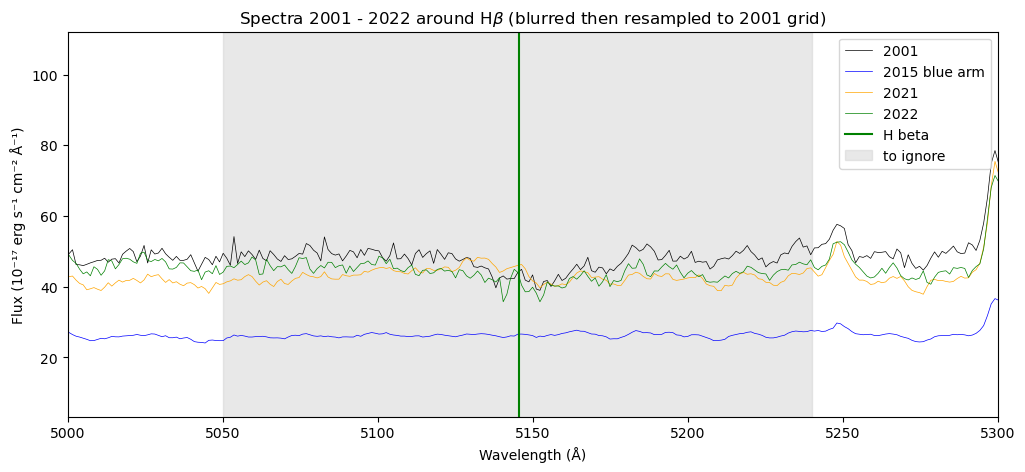

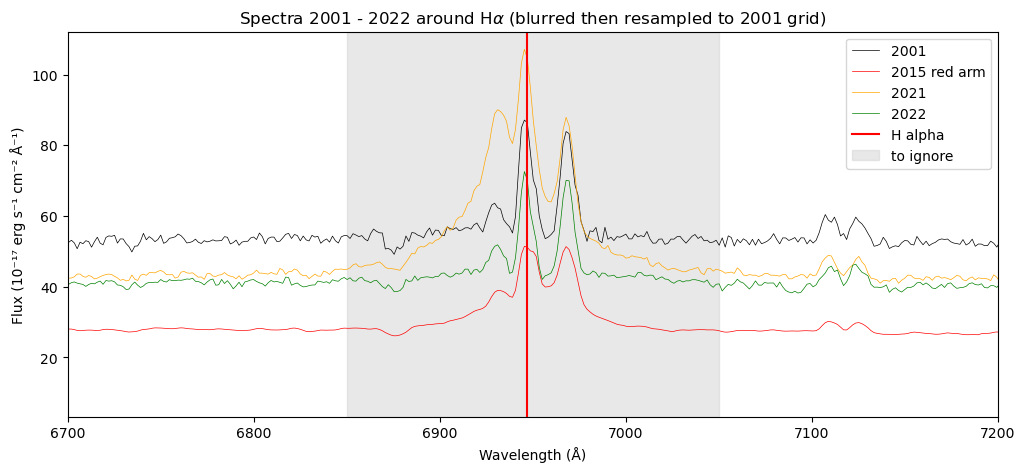

In [206]:
linewidth = 0.5

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_blurred_shifted, color='black', label='2001', lw = linewidth)
plt.plot(lam01, flux15_blurred_shifted, color='blue', label='2015 blue arm', lw = linewidth)
plt.plot(lam01, flux21_blurred_shifted, color='orange', label='2021', lw = linewidth)
plt.plot(lam01, flux22_blurred_shifted, color='green', label='2022', lw = linewidth)
plt.xlim((5000, 5300))
plt.xlabel("Wavelength (Å)")
plt.axvline((1+z)*H_BETA, color='g', label="H beta")
plt.axvspan(5050, 5240, color='lightgrey', alpha=0.5, label="to ignore")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title(r"Spectra 2001 - 2022 around H$\beta$ (blurred then resampled to 2001 grid)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(lam01, flux01_blurred_shifted, color='black', label='2001', lw = linewidth)
plt.plot(lam01, flux15_blurred_shifted, color='red', label='2015 red arm', lw = linewidth)
plt.plot(lam01, flux21_blurred_shifted, color='orange', label='2021', lw = linewidth)
plt.plot(lam01, flux22_blurred_shifted, color='green', label='2022', lw = linewidth)
plt.xlim((6700, 7200))
plt.axvline((1+z)*H_ALPH, color='r', label="H alpha")
plt.axvspan(6850, 7050, color='lightgrey', alpha=0.5, label="to ignore")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title(r"Spectra 2001 - 2022 around H$\alpha$ (blurred then resampled to 2001 grid)")
plt.legend()
plt.show()

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


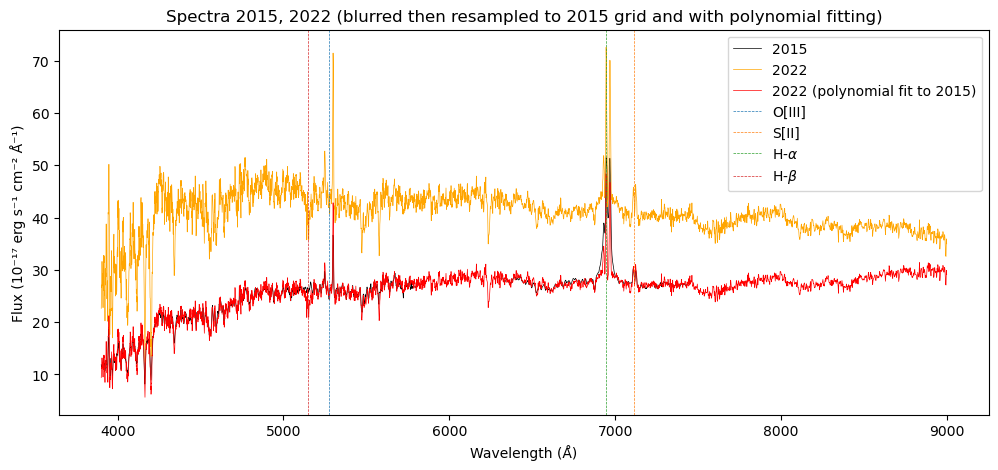

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


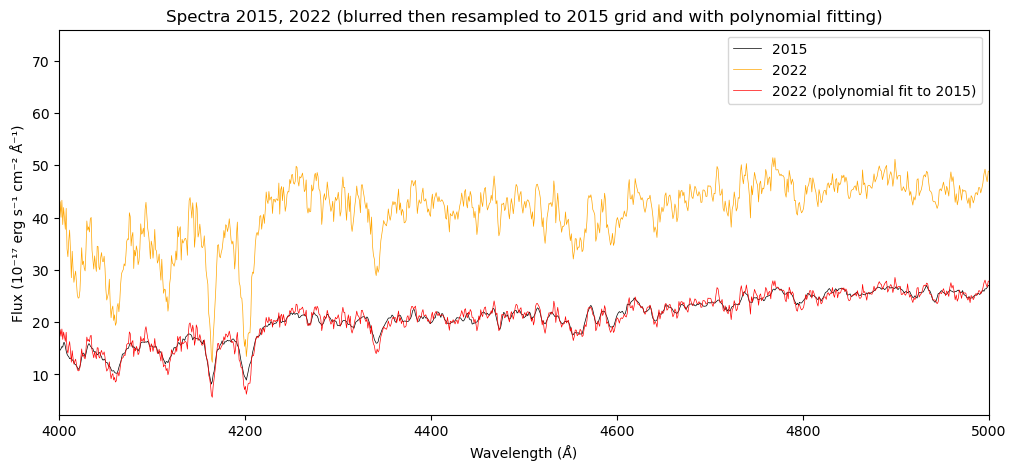

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


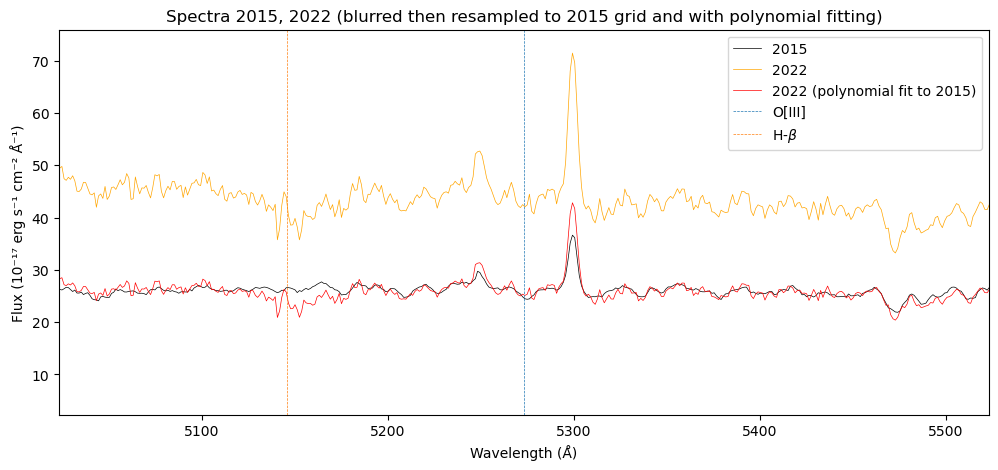

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


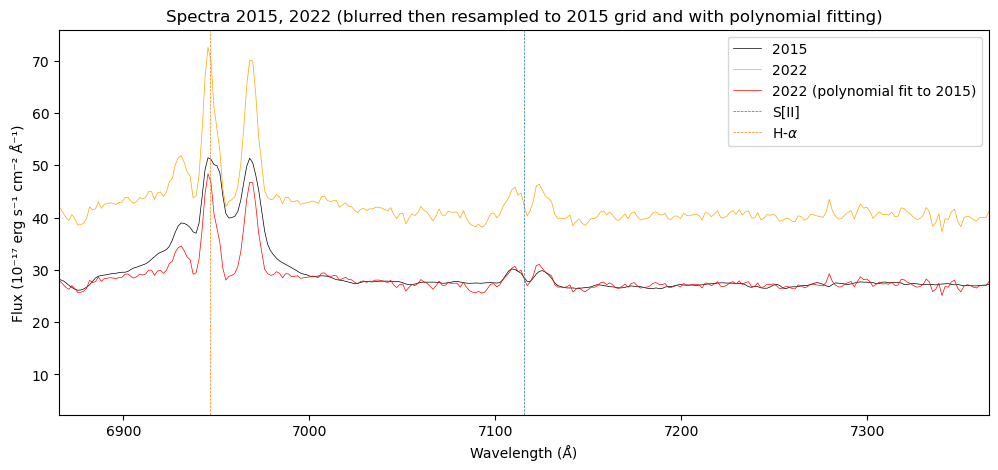

In [207]:
year = "2022"

H_ALPH_dict = {r"H-${\alpha}$": H_ALPH*(1+z)}
H_BETA_dict = {r"H-${\beta}$": H_BETA*(1+z)}
OIII_dict = {"O[III]": OIII*(1+z)}
SII_dict = {"S[II]": SII*(1+z)}
vlines = OIII_dict | SII_dict | H_ALPH_dict | H_BETA_dict
width = 500

adjust_calibration(
    year_to_change=year, plot_ratio_selection=False,
    plot_poly_ratio=False, plot_adjusted=True,
    vlines=vlines
);
adjust_calibration(
    year_to_change=year, plot_ratio_selection=False,
    plot_poly_ratio=False, plot_adjusted=True,
    adjusted_plot_lam_bounds=(4000, 5000)
);
adjust_calibration(
    year_to_change=year, plot_ratio_selection=False,
    plot_poly_ratio=False, plot_adjusted=True,
    adjusted_plot_lam_bounds=get_lam_bounds(OIII, width),
    vlines=(OIII_dict | H_BETA_dict)
);
adjust_calibration(
    year_to_change=year, plot_ratio_selection=False,
    plot_poly_ratio=False, plot_adjusted=True,
    adjusted_plot_lam_bounds=get_lam_bounds(SII, width),
    vlines=(SII_dict | H_ALPH_dict)
);

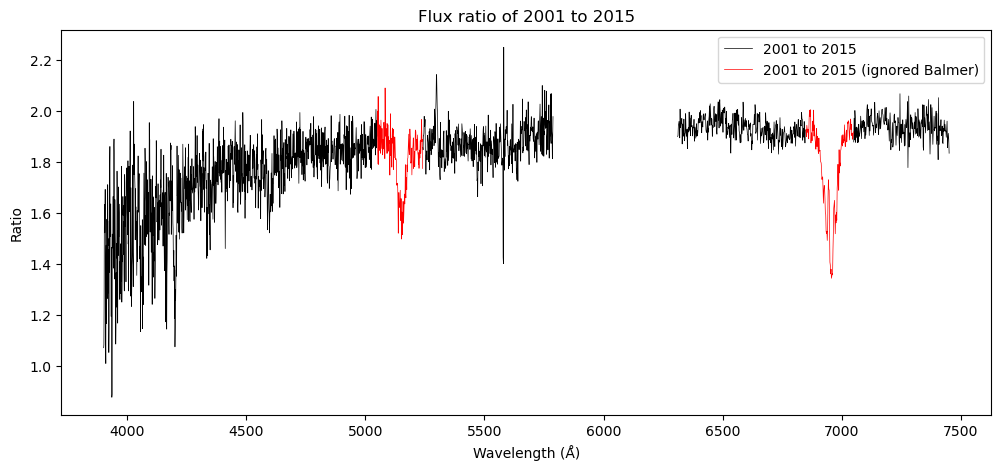

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


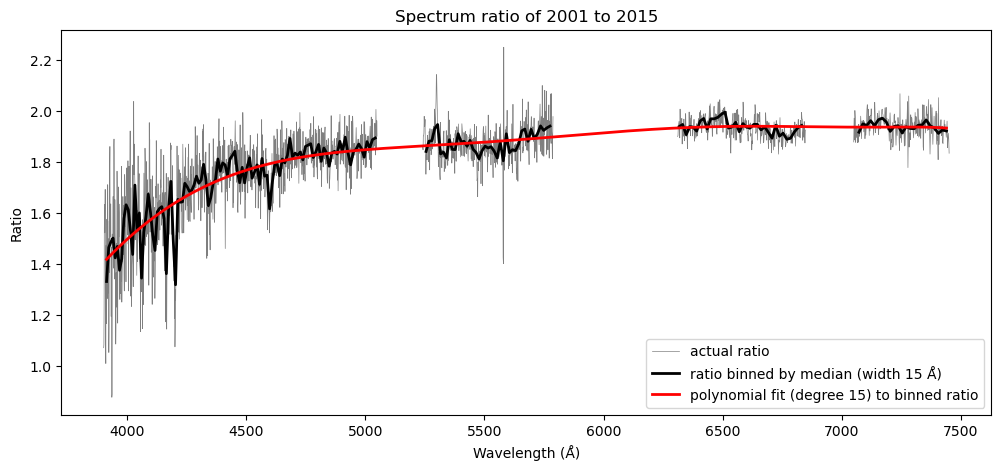

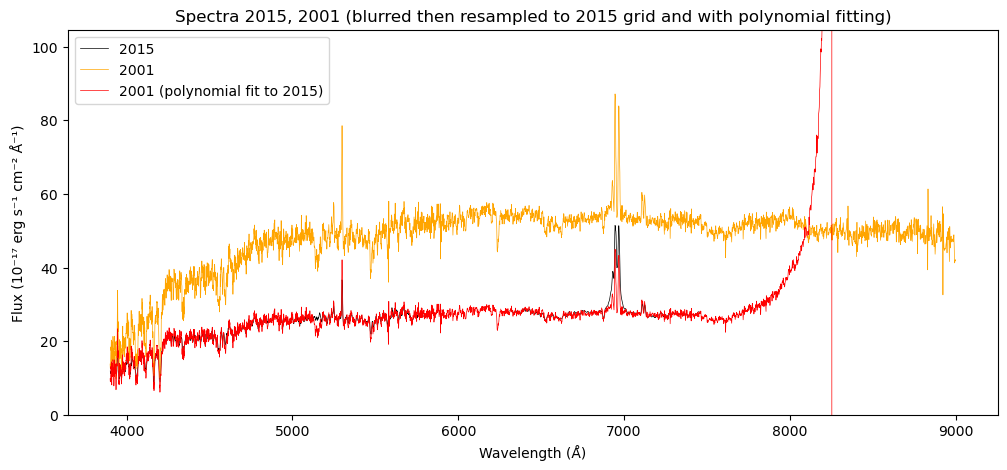

In [208]:
_, adjusted_01_flux_15 = adjust_calibration(year_to_change="2001", bin_width=15, poly_degree=15)

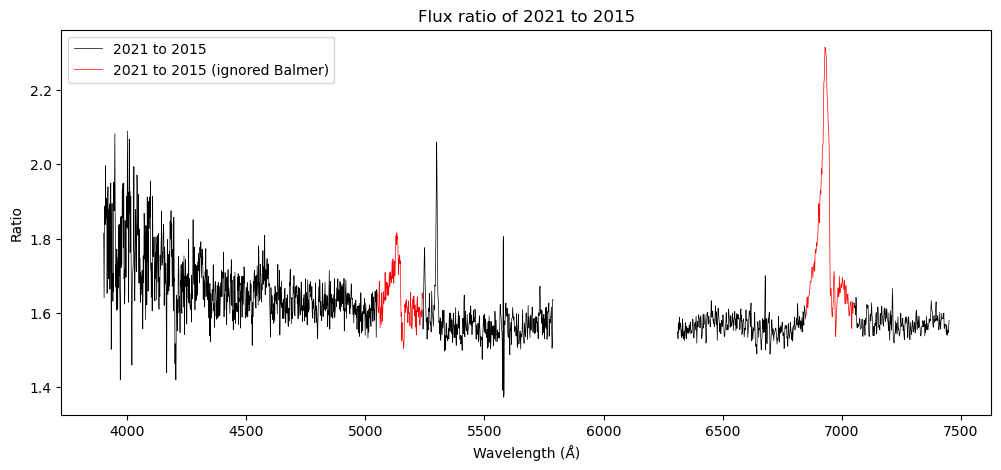

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


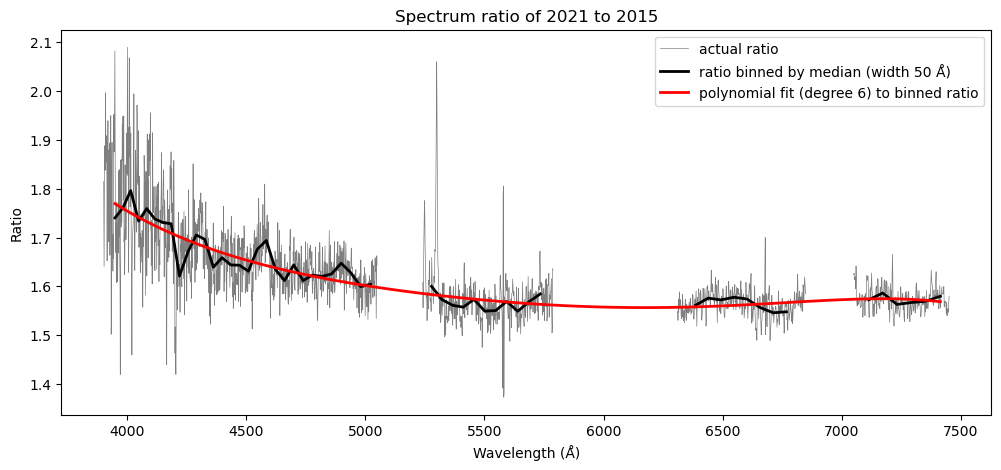

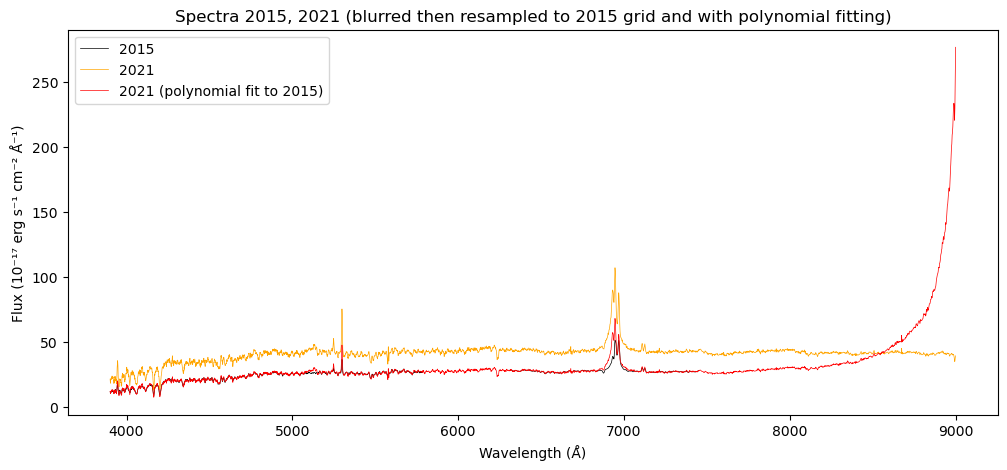

In [209]:
_, adjusted_21_flux_15 = adjust_calibration(year_to_change="2021")


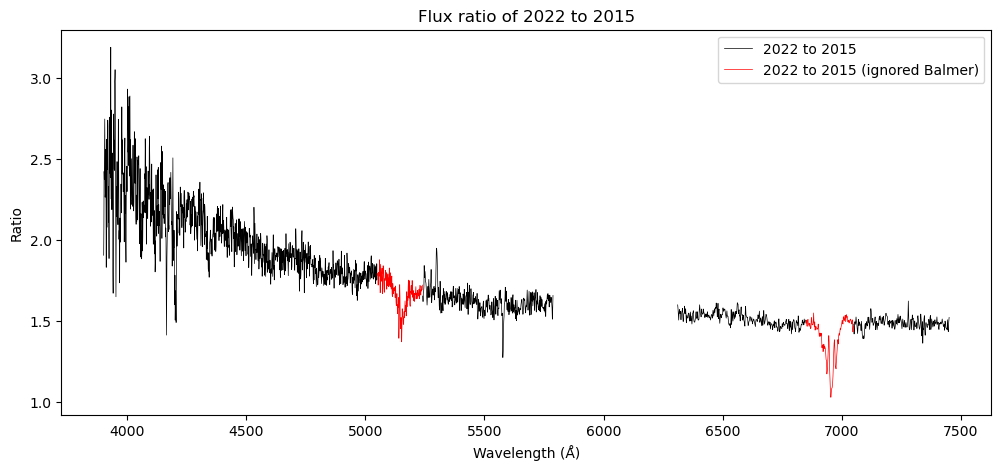

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_21508/3991522120.py:35: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


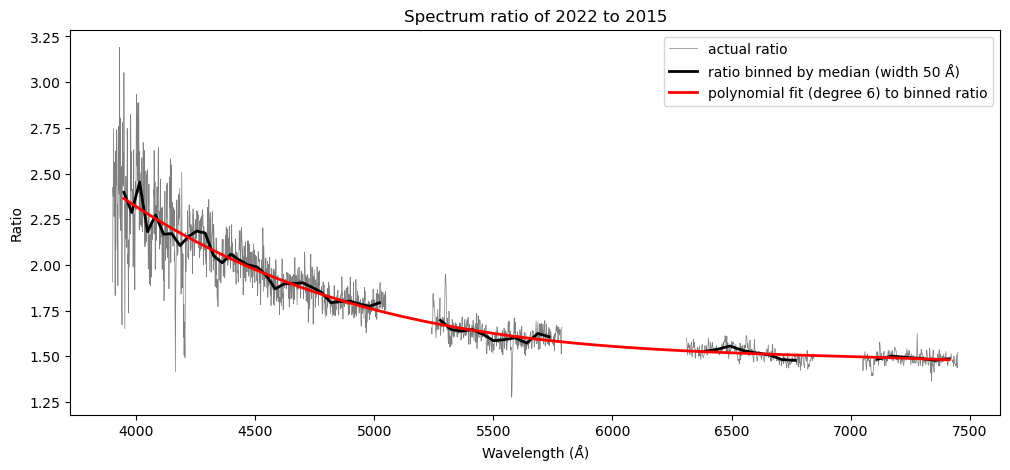

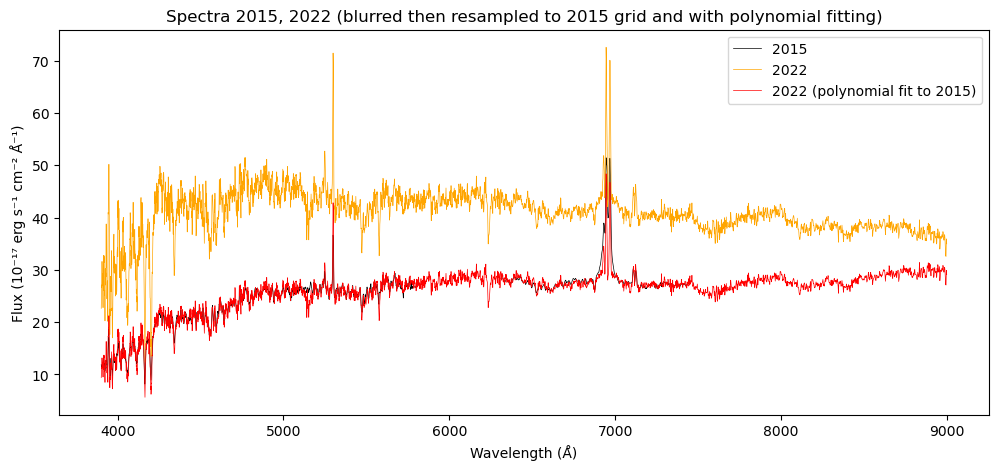

In [210]:
_, adjusted_22_flux_15 = adjust_calibration(year_to_change="2022")

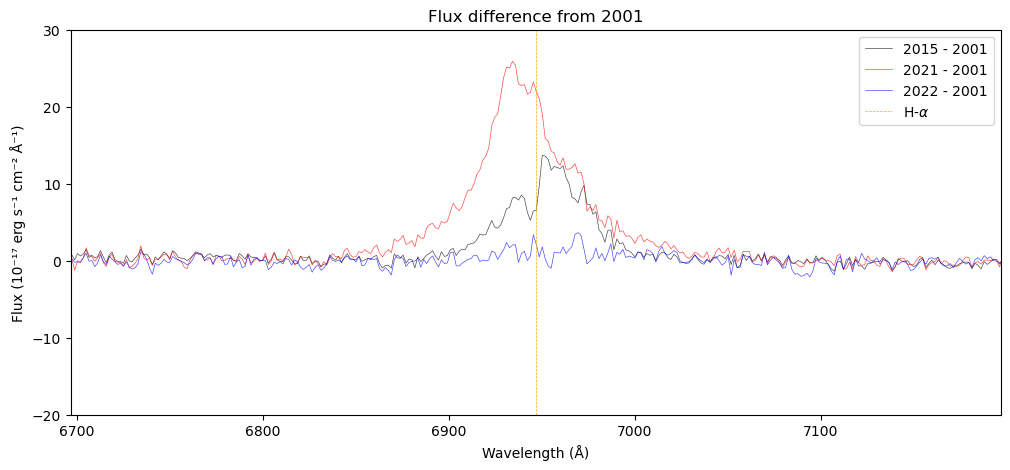

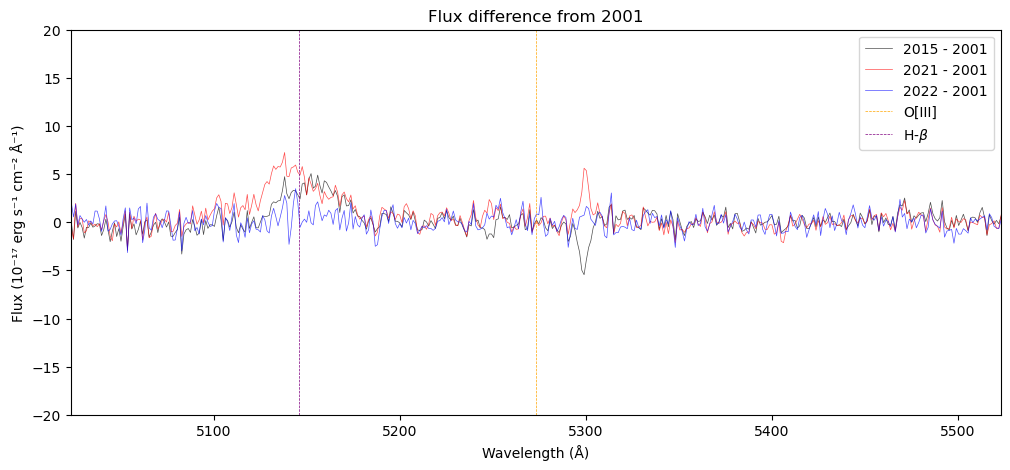

In [211]:
# calibration_year = 2001

# diff_15_red_01 = adjusted_15_red_flux - flux01_blurred
# diff_15_blue_01 = adjusted_15_blue_flux - flux01_blurred
# diff_15_01 = np.fmax(diff_15_red_01, diff_15_blue_01)

# diff_15_01 = adjusted_15_flux - flux01_blurred
# diff_21_01 = adjusted_21_flux - flux01_blurred
# diff_22_01 = adjusted_22_flux - flux01_blurred

diff_year = 2001

diff_15_01 = flux15_blurred_shifted - adjusted_01_flux_15
diff_21_01 = adjusted_21_flux_15 - adjusted_01_flux_15
diff_22_01 = adjusted_22_flux_15 - adjusted_01_flux_15

plt.figure(figsize=(12,5))
plt.plot(lam01, diff_15_01, alpha=0.7, color='black', label=f'2015 - {diff_year}', lw = linewidth)
plt.plot(lam01, diff_21_01, alpha=0.7, color='red', label=f'2021 - {diff_year}', lw = linewidth)
plt.plot(lam01, diff_22_01, alpha=0.7, color='blue', label=f'2022 - {diff_year}', lw = linewidth)

# plt.xlim(get_lam_bounds(SII, width))
# plt.axvline(SII*(1+z), linestyle="--", color='orange', label="S[II]", lw=linewidth)
# plt.axvline(H_ALPH*(1+z), linestyle="--", color='purple', label=r"H-$\alpha$", lw=linewidth)

# plt.xlim(get_lam_bounds(OIII, width))
# plt.axvline(OIII*(1+z), linestyle="--", color='orange', label="O[III]", lw=linewidth)
# plt.axvline(H_BETA*(1+z), linestyle="--", color='purple', label=r"H-$\beta$", lw=linewidth)

plt.xlim(get_lam_bounds(H_ALPH, width))
plt.axvline(H_ALPH*(1+z), linestyle="--", color='orange', label=r"H-$\alpha$", lw=linewidth)
plt.ylim((-20, 30))

# plt.xlim(get_lam_bounds(H_BETA, 0.5*width))
# plt.axvline(H_BETA*(1+z), linestyle="--", color='purple', label=r"H-$\beta$", lw=linewidth)
# plt.ylim((-10, 15))

# plt.xlim((4000, 7500))


plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title(f"Flux difference from {diff_year}")
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
plt.plot(lam01, diff_15_01, alpha=0.7, color='black', label=f'2015 - {diff_year}', lw = linewidth)
plt.plot(lam01, diff_21_01, alpha=0.7, color='red', label=f'2021 - {diff_year}', lw = linewidth)
plt.plot(lam01, diff_22_01, alpha=0.7, color='blue', label=f'2022 - {diff_year}', lw = linewidth)

plt.xlim(get_lam_bounds(OIII, width))
plt.axvline(OIII*(1+z), linestyle="--", color='orange', label="O[III]", lw=linewidth)
plt.axvline(H_BETA*(1+z), linestyle="--", color='purple', label=r"H-$\beta$", lw=linewidth)
plt.ylim((-20, 20))

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title(f"Flux difference from {diff_year}")
plt.legend()
plt.show()

# Gaussian fit
fitting to the H alpha line!

In [212]:
#TODO: apply to my code
#TODO: calculate balmer decrement in bins

# limiting range to close to the H alpha line
idx = np.where((lam01 > 6700) & (lam01 < 7200))
x = lam01[idx]
y = diff_15_01[idx]
sig = sigma_diff[idx]
sig[sig == 0] = np.min(sig[sig > 0]) ## dealing with division by 0

# Compute weights for the fitting
weights = 1.0 / sig

# establishing initial guesses for the fit
peaks, properties = find_peaks(y, height=np.std(y)*3, distance=3)  # tweak height/distance
peaks = peaks[:2]       ## change this depending on how many peaks you want captured
mu_guesses = x[peaks]
amp_guesses = properties["peak_heights"]
results_half = peak_widths(y, peaks, rel_height=0.5)
sigma_guesses = results_half[0] * (x[1] - x[0]) / (2*np.sqrt(2*np.log(2)))  # convert FWHM → stddev


# perform the fit:
model = None
params = None

for i, (amp, mu, sigma) in enumerate(zip(amp_guesses, mu_guesses, sigma_guesses)):
    prefix = f"g{i}_"
    g = GaussianModel(prefix=prefix)
    if model is None:
        model = g
        params = g.make_params()
    else:
        model += g
        params.update(g.make_params())
    
    # set parameter guesses
    params[prefix+'amplitude'].set(value=amp*np.sqrt(2*np.pi)*sigma, min=0)
    params[prefix+'center'].set(value=mu)
    params[prefix+'sigma'].set(value=sigma, min=0.1)


result = model.fit(y, params, x=x, weights=weights)
#print(result.fit_report()) #uncomment if you want the fit report!


# Plot the outcome!
redchisq = result.redchi    # lmfit stores reduced chisq here
plt.figure(figsize=(10,6))
plt.plot(x, y, label="Data", alpha=0.6)
plt.plot(x, result.best_fit, 'r-', label="Total fit", linewidth=2)

# Plot each component separately
for name, comp in result.eval_components(x=x).items():
    plt.plot(x, comp, '--', label=name)

# Plot uncertainty band (gray stripe)
plt.fill_between(
    x,
    y - sig,
    y + sig,
    color="gray",
    alpha=0.3,
    label="Uncertainty"
)
plt.ylabel('Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)')
plt.xlabel("Wavelength (Å)")
plt.title("Multi-Gaussian Fit Hα 2021 Difference Spectrum")
    
plt.text(
    0.05, 0.95,         
    f"Reduced χ² = {result.redchi:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.legend()
plt.show()

NameError: name 'sigma_diff' is not defined

## Extracting fit parameters with monte carlo sampling
for the full width at half maximum and the luminosity (from integrated flux)

note: if you only fit one gaussian, you can find the fwhm + uncertainty in the fit report

In [ ]:
def fwhm_from_fit(x, y, sig, model, params, n_trials):
    # n_trials = no. of monte carlo samples
  fwhm_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
    y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

    result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) # refit model

    #compute fwhm
    y_fit_mc = result_mc.best_fit
    half_max = np.max(y_fit_mc) / 2
    above_half = np.where(y_fit_mc >= half_max)[0]
    if len(above_half) > 1:
      fwhm = x[above_half[-1]] - x[above_half[0]]
      fwhm_list.append(fwhm)

  # extract values
  fwhm_mean = np.mean(fwhm_list) * u.AA
  fwhm_std = np.std(fwhm_list) * u.AA

  # convert to km/s
  rest_wavelength = 6562.8 * u.AA  # Hα rest wavelength
  fwhm_vel = (fwhm_mean / rest_wavelength) * c.to(u.km/u.s)
  fwhm_vel_err = (fwhm_std / rest_wavelength)* c.to(u.km/u.s)

  return fwhm_vel, fwhm_vel_err


In [ ]:
def lum_from_fit(x, y, sig, model, params, n_trials):
  trapflux_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
      y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

      result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) #refit model

      y_fit_mc = result_mc.best_fit
      trapflux = np.trapz(y_fit_mc, x)  #integrate with trapezoidal rule
      trapflux_list.append(trapflux)

  # extract values: mean and sd of the sampled integrals
  trap_mean = np.mean(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  trap_std = np.std(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  
  # Luminosity distance
  z = 0.0582
  d = cosmo.luminosity_distance(z)
  d = d.to(u.cm)

  # compute luminosity
  luminosity = trap_mean * 4 * np.pi * (d**2)
  lum_err = trap_std * 4 * np.pi * (d**2)

  return luminosity, lum_err


Note: this will take a while to run! lower the number of samples to test

In [ ]:
fwhm_velocity_ha, fwhm_vel_err_ha = fwhm_from_fit(x, y, sig, model, params, 500)
luminosity_ha, lum_err_ha = lum_from_fit(x, y, sig, model, params, 500)

In [ ]:
print(f"fwhm: {fwhm_velocity_ha:.2e} ± {fwhm_vel_err_ha:.2e} ")
print(f"luminosity: {luminosity_ha:.2e} ± {lum_err_ha:.2e} ")

### Then to find BH mass!

In [ ]:
def bh_mass(l_ha, l_ha_err, fwhm_ha, fwhm_ha_err):
    """
    Estimate BH mass from Halpha line. Using the equation from Greene & Ho 2005
    
    Parameters:
    l_ha : Halpha luminosity in erg/s (with error l_ha_err)
    fwhm_ha : Halpha line FWHM in km/s (with error fwhm_ha_err)

    Returns:
    mbh : Black hole mass in solar masses (with error mbh_err)
    Note: mbh_err calculated using log(mass) for easier calculation
    """
    coeff = 2.0e6  
    exp_l = 0.55
    exp_fwhm = 2.06

    # Normalize inputs
    l_norm = l_ha / 1e42
    fwhm_norm = fwhm_ha / 1e3 
    mbh = coeff * (l_norm**exp_l) * (fwhm_norm**exp_fwhm)

    # uncertainty (using log(mass))
    sig_loglum = (1/np.log(10)) * (l_ha_err / l_ha)
    sig_logfwhm = (1/np.log(10)) * (fwhm_ha_err / fwhm_ha)
    sig_loga = (1/np.log(10)) * (0.35 / 2)
    sig_b = 0.02
    sig_c = 0.06
    b = 0.55
    c = 2.06

    
    var_logm = (sig_loga)**2 + (np.log10(l_ha/(10**42)) * sig_b)**2 + (b*sig_loglum)**2 + (np.log10(fwhm_ha/(10**3)) * sig_c)**2 + (c*sig_logfwhm)**2

    sig_logm = np.sqrt(var_logm)
    mbh_err = np.log(10) * mbh * sig_logm

    return mbh, mbh_err


mass, sig_m = bh_mass(luminosity_ha.value, lum_err_ha.value, fwhm_velocity_ha.value, fwhm_vel_err_ha.value)
print(f"Estimated black hole mass: {mass:.2e} ± {sig_m:.2e} M_sun")

## D4000 functions

From Scott Croom

In [ ]:
#Conversion from FWHM to Gaussian sigma
FWHM_sigma=2.0*np.sqrt(2.0*np.log(2.0))

##A Gaussian function
#x=independenat variable
#a=amplitude
#b=phase shift (left or right)
#c=sigma
#d=zero-point offset (up or down)
def gaussian(x,a,b,c,d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d

## Convert fluxes per Angstrom to fluxes per pixel
#wave=Wavelength vector
#spec=spectrum in units of flux per angstrom
def flux_per_pix(wave,spec):
    d_lam=[]
    for i in range(1,len(wave)):
        d_lam.append(wave[i]-wave[i-1])
    d_lam.append(d_lam[-1])
    d_lam=np.array(d_lam)
    return spec*d_lam

#resolution at which to calculate indices. 
#These values should be sigmas in Angstroms
lick_res={'D4000': 11.0/FWHM_sigma,   #This may not be the right resolution. Was 16 A FWHM in Balogh et al. 1999, but smoothing may not have been applied in subsequent papers. Ask Nic Scott!
          'Hdelta_A': 10.0/FWHM_sigma,
          'Ca4227': 9.0/FWHM_sigma,
          'G4300': 9.5/FWHM_sigma,
          'Fe4383': 9.0/FWHM_sigma,
          'Fe5270': 8.4/FWHM_sigma,
          'Hbeta':8.4/FWHM_sigma,
          'Mg_b': 8.4/FWHM_sigma,
          'CN_1': 10.0/FWHM_sigma,
          'CN_2': 10.0/FWHM_sigma        
}

#Index passbands in order of increasing wavelength
lick_window={'D4000_1':[3850.0,3950.0],  #Index invented by Balogh et al. 1999
             'D4000_2':[4000.0,4100.0],  #Index invented by Balogh et al. 1999
             'Mg_b_1':[4041.60,4079.75],  #Worthey & Ottaviani 1997
             'Mg_b_2':[4083.50,4122.25],
             'Mg_b_3':[4128.50,4161.00],
             'Ca4227_1':[4211.000,4219.750], #Lick system
             'Ca4227_2':[4222.250,4234.750],
             'Ca4227_3':[4241.000,4251.000],
             'G4300_1':[4266.375,4282.625], #Lick system
             'G4300_2':[4281.375,4316.375],
             'G4300_3':[4318.875,4335.125],
             'Fe4383_1':[4359.125,4370.375],
             'Fe4383_2':[4369.125,4420.375],
             'Fe4383_3':[4442.875,4455.375], # maybe this
             'Fe5270_1':[5233.150,5248.150],
             'Fe5270_2':[5245.650,5285.650],
             'Fe5270_3':[5285.650,5318.150],
             'Hbeta_1':[4827.875,4847.875],
             'Hbeta_2':[4847.875,4876.625],
             'Hbeta_3':[4876.625,4891.625],
             'Mg_b_1':[5142.625,5161.375], # this
             'Mg_b_2':[5160.125,5192.625],
             'Mg_b_3':[5191.375,5206.375],
             'CN_1_1':[4080.125,4117.625],
             'CN_1_2':[4142.125,4177.125],
             'CN_1_3':[4244.125,4284.125],
             'CN_2_1':[4083.875,4096.375],
             'CN_2_2':[4142.125,4177.125],
             'CN_2_3':[4244.125,4284.125]
}

## This function will blur the spectrum to the appropriate resolution.
#wavelength=wavelength vector
#spec=spectrum
#res_in=Native resolution in Angstroms. Sigma, not FWHM.
#res_out=Desired resolution of the spectrum
#Disp_cor=dispersion correction for high velocity dispersion spectra. Default=0
def blur_spectrum(wavelength,spec,res_in,res_out,disp_cor=0):
    res_ker=np.sqrt(res_out**2 - res_in**2 - disp_cor**2)
    kernel=(1.0/np.sqrt(2*np.pi*res_ker**2))*gaussian(wavelength,1.0,np.median(wavelength),res_ker,0)
    spec_smooth=sp.signal.convolve(np.nan_to_num(spec),kernel,mode='same')
    transfer=np.ones(spec.shape)
    badpix=np.where(np.isnan(spec)==True)
    transfer[badpix]=0
    transfer_smooth=sp.signal.convolve(transfer,kernel,mode='same')
    return spec_smooth/transfer_smooth

def flam_fnu(wave,flam):
    return (flam*wave**2)/(c*10**13)


In [ ]:
##D4000 index
#wave=wavelength scale
#spec=input spectrum
#z=redshift of the spectrum
#res=native resolution of the spectrum
def D4000_w_errs(wave,spec,var,z,res=None):
    '''
    A calculation of Dn4000 that gives an error estimate too 
    '''
    ind_res=lick_res['D4000']
    if res!=None:
        spec_smooth=blur_spectrum(wave,spec,res,ind_res)
    else:
        spec_smooth=spec
    spec_smooth=flam_fnu(wave,spec_smooth)
    spec_smooth=flux_per_pix(wave,spec_smooth)
    # Adam's version
    #ind1=array_if(spec_smooth,(wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    #ind2=array_if(spec_smooth,(wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    #d1=np.nanmean(ind1)
    #d2=np.nanmean(ind2)
    # should do the same, but getting indices:
    idx1 = np.where((wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    idx2 = np.where((wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    d1 = np.nanmean(spec_smooth[idx1])
    d2 = np.nanmean(spec_smooth[idx2])
    
    d4000=d2/d1
    #Compute errors. Need variance spectrum first...
    ##
    var=var*((wave**2)/(c*10**13))**2
    var=flux_per_pix(wave,var) #conversion from wavelength to frequency
    var=flux_per_pix(wave,var) #I have to do this twice becasue you multiply variance by square of number
    #var_ind1=array_if(var,(wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    #var_ind2=array_if(var,(wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #v1=np.sum(var_ind1)/(len(var_ind1)**2)
    #v2=np.sum(var_ind2)/(len(var_ind2)**2)
    
    vidx1=np.where((wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    vidx2=np.where((wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))

    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    # need to check th scaling and nan handling...
    v1=np.nansum(var[vidx1])/(len(var[vidx1])**2)
    v2=np.nansum(var[vidx2])/(len(var[vidx2])**2)
    s1=np.sqrt(v1)
    s2=np.sqrt(v2)
    d4000_err=d4000*np.sqrt((s1/d1)**2 + (s2/d2)**2)
    return d4000,d4000_err

Generalised index function

In [ ]:
#idx_name=name of index - e.g. Mg_b or Hdelta_A. must have 3 indices in lick_window
#wave=wavelength scale
#spec=input spectrum
#z=redshift of the spectrum
#res=resolution in Angstroms. Sigma, not FWHM.
def idx_w_errs(
    idx_name: str,
    wave: np.ndarray,
    spec: np.ndarray,
    var: np.ndarray,
    z: float,
    res: float | None = None
) -> tuple[float, float]:
    ind_res=lick_res[idx_name]
    if res!=None:
        spec_smooth=blur_spectrum(wave,spec,res,ind_res)
    else:
        spec_smooth=spec
    spec_smooth=flux_per_pix(wave,spec_smooth)
    #ind1=array_if(spec_smooth,(wave>=lick_window['Mg_b_1'][0]*(1+z)) & (wave<=lick_window['Mg_b_1'][1]*(1+z)))
    #ind2=array_if(spec_smooth,(wave>=lick_window['Mg_b_2'][0]*(1+z)) & (wave<=lick_window['Mg_b_2'][1]*(1+z)))
    #ind3=array_if(spec_smooth,(wave>=lick_window['Mg_b_3'][0]*(1+z)) & (wave<=lick_window['Mg_b_3'][1]*(1+z)))
    #hda1=np.nanmean(ind1)
    #hda2=np.nanmean(ind2)
    #hda3=np.nanmean(ind3)
    idx1=np.where((wave>=lick_window[idx_name + '_1'][0]*(1+z)) & (wave<=lick_window[idx_name + '_1'][1]*(1+z)))
    idx2=np.where((wave>=lick_window[idx_name + '_2'][0]*(1+z)) & (wave<=lick_window[idx_name + '_2'][1]*(1+z)))
    idx3=np.where((wave>=lick_window[idx_name + '_3'][0]*(1+z)) & (wave<=lick_window[idx_name + '_3'][1]*(1+z)))
    named_lick1=np.nanmean(spec_smooth[idx1])
    named_lick2=np.nanmean(spec_smooth[idx2])
    named_lick3=np.nanmean(spec_smooth[idx3])
    named_lick_sideband=np.nanmean([named_lick1,named_lick3])
    named_index=named_lick2
    lam1=lick_window[idx_name + '_2'][0]*(1+z)
    lam2=lick_window[idx_name + '_2'][1]*(1+z)
    named_lick=(lam2-lam1)*(1-named_index/named_lick_sideband)
    ##Now calculate the error
    var=flux_per_pix(wave,var)
    var=flux_per_pix(wave,var) #I have to do this twice becasue you multiply variance by square of number
    #var_ind1=array_if(var,(wave>=lick_window['Mg_b_1'][0]*(1+z)) & (wave<=lick_window['Mg_b_1'][1]*(1+z)))
    #var_ind2=array_if(var,(wave>=lick_window['Mg_b_2'][0]*(1+z)) & (wave<=lick_window['Mg_b_2'][1]*(1+z)))
    #var_ind3=array_if(var,(wave>=lick_window['Mg_b_3'][0]*(1+z)) & (wave<=lick_window['Mg_b_3'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #[var_ind3]=reject_invalid([var_ind3])
    #v1=np.sum(var_ind1)/(len(var_ind1)**2)
    #v2=np.sum(var_ind2)/(len(var_ind2)**2)
    #v3=np.sum(var_ind3)/(len(var_ind3)**2)
    vidx1=np.where((wave>=lick_window[idx_name + '_1'][0]*(1+z)) & (wave<=lick_window[idx_name + '_1'][1]*(1+z)))
    vidx2=np.where((wave>=lick_window[idx_name + '_2'][0]*(1+z)) & (wave<=lick_window[idx_name + '_2'][1]*(1+z)))
    vidx3=np.where((wave>=lick_window[idx_name + '_3'][0]*(1+z)) & (wave<=lick_window[idx_name + '_3'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #[var_ind3]=reject_invalid([var_ind3])
    v1=np.nansum(var[vidx1])/(len(var[idx1])**2)
    v2=np.nansum(var[vidx2])/(len(var[idx2])**2)
    v3=np.nansum(var[vidx3])/(len(var[idx3])**2)
    v_sb=(v1 + v3) / 4.0
    s_sb=np.sqrt(v_sb)
    s_i=np.sqrt(v2)
    named_lick_err=np.abs(named_lick)*(lam2-lam1)*np.sqrt((s_sb/named_lick_sideband)**2 + (s_i/named_index)**2)
    return named_lick, named_lick_err

## Finding D4000 and other indices across different epochs

In [ ]:
blue_lambdas = [lam01, lam15_blue, lam21, lam22]
blue_fluxes = [flux01, flux15_blue, flux21, flux22]
blue_variances = [var01, var15_blue, var21, var22]
# blue_fluxes = [flux01, flux15_blue_shifted, flux21_shifted, flux22_shifted]
# blue_variances = [var01, var15_blue_shifted, var21_shifted, var22_shifted]

#TODO: make dict and plot instead of print
idx_names = ["Hbeta", "Mg_b", "Fe4383"]

for i, year in enumerate([2001, 2015, 2021, 2022]):
    D4000_idx, D4000_idx_err = D4000_w_errs(blue_lambdas[i], blue_fluxes[i], blue_variances[i], z)
    print(f"\nD4000 index for year {year}: {D4000_idx} with error {D4000_idx_err}")
    for idx_name in idx_names:
        idx, idx_err = idx_w_errs(idx_name, blue_lambdas[i], blue_fluxes[i], blue_variances[i], z)
        print(f"{idx_name} index for year {year}: {idx} with error {idx_err}")


D4000 index for year 2001: 1.6460033496720625 with error 0.014845390284861431
Hbeta index for year 2001: 2.661154270172119 with error 0.7261463403701782
Mg_b index for year 2001: 2.6782243251800537 with error 0.8020838499069214
Fe4383 index for year 2001: 4.106278419494629 with error 2.197388172149658

D4000 index for year 2015: 1.4707835639092108 with error 0.0008199252342145983
Hbeta index for year 2015: 0.16788428481485163 with error 0.002137266403660744
Mg_b index for year 2015: 1.9029200540146776 with error 0.02706068533496769
Fe4383 index for year 2015: 3.642875998773093 with error 0.09959253877892638

D4000 index for year 2021: 1.4802788724200981 with error 0.006578790446541162
Hbeta index for year 2021: -0.1789793223142624 with error 0.030251597985625267
Mg_b index for year 2021: 2.4467504024505615 with error 0.48727840185165405
Fe4383 index for year 2021: 3.932420253753662 with error 1.2700015306472778

D4000 index for year 2022: 1.4786102813526731 with error 0.01117777492391

## Modified version of Tyler's normalisation attempt 

<Figure size 640x480 with 0 Axes>

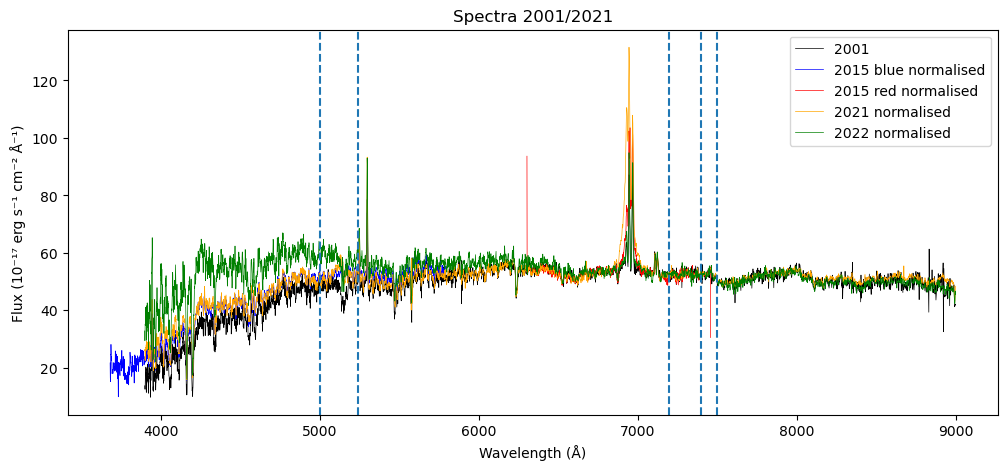

In [ ]:
##now to normalise each one and calculate a new difference spectrum
nidx_22 = np.where((lam22 > 7200) & (lam22 < 7500))
sec_22 = flux22[nidx_22]
mean_22 = np.mean(sec_22)

nidx_21 = np.where((lam21 > 7200) & (lam21 < 7500))  #7200-7500A is a section with no significant spectral lines - baseline seciton
sec_21 = flux21[nidx_21]
mean_21 = np.mean(sec_21)

nidx_15_blue = np.where((lam15_blue > 5000) & (lam15_blue < 5240))
sec_15_blue = flux15_blue[nidx_15_blue]
mean_15_blue = np.mean(sec_15_blue)

nidx_15_red = np.where((lam15_red > 7200) & (lam15_red < 7400))
sec_15_red = flux15_red[nidx_15_red]
mean_15_red = np.mean(sec_15_red)

nidx_01 = np.where((lam01 > 7200) & (lam01 < 7500))
sec_01 = flux01[nidx_01]
mean_01 = np.mean(sec_01)

ratio_22_01 = mean_01 / mean_22
ratio_21_01 = mean_01 / mean_21
ratio_15_blue_01 = mean_01 / mean_15_blue # red instead?
ratio_15_red_01 = mean_01 / mean_15_red

norm15_blue = flux15_blue * ratio_15_blue_01
norm15_red = flux15_red * ratio_15_red_01
norm21 = flux21 * ratio_21_01
norm22 = flux22 * ratio_22_01


# accounts for normalization
a = mean_21 / mean_01
var_norm01 = (a**2) * var01

#plotting normalised spectra
plt.clf()
plt.figure(figsize=(12,5))
plt.plot(lam01, flux01, color='black', label='2001', lw = linewidth)
plt.plot(lam15_blue, norm15_blue, color='blue', label='2015 blue normalised', lw = linewidth)
plt.plot(lam15_red, norm15_red, color='red', label='2015 red normalised', lw = linewidth)
plt.plot(lam21, norm21, color='orange', label='2021 normalised', lw = linewidth)
plt.plot(lam22, norm22, color='green', label='2022 normalised', lw = linewidth)
plt.axvline(7200, linestyle='--')
plt.axvline(7400, linestyle='--')
plt.axvline(7500, linestyle='--')
plt.axvline(5000, linestyle='--')
plt.axvline(5240, linestyle='--')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001/2021")
plt.legend()
plt.show()